In [1]:
import collections
import matplotlib.pyplot as plt
import getpass
import glob
import itertools
import json
import numpy as np
import os
import openml
import pandas as pd
import scipy.stats

from plot_utils.style import style_dc
from plot_utils.common_plots import rank, average_plot
from plot_utils.common_tables import collect_data_for_final_table, do_wilcoxon_test
from plot_utils.common_loading import load_from_openml

import sys
sys.path.append("/home/eggenspk/Work/Project/2020_PoSH_Autosklearn/2020_IEEE_Autosklearn_experiments/experiment_scripts/")
sys.path.append("/home/feurerm/sync_dir/projects/2020_posh/2020_IEEE_Autosklearn_experiments/experiment_scripts")
from utils import openml_automl_benchmark, automl_test_benchmark, get_normalization_constants

In [2]:
username = getpass.getuser()
dir_ = {
    'eggenspk': "/home/eggenspk/Work/data/ASKL_20/",
    'feurerm': "/home/feurerm/projects/2021_posh_new/",
}[username]

valid_pretty = {
    #1: {
    #(None, "1MIN/RQ1_AutoAuto_simulate/dynamic/"): "All",
    #(None, "1MIN/RQ2.1_AutoAuto_simulate/no_cv/dynamic/"): "Only Holdout",
    #(None, "1MIN/RQ2.1_AutoAuto_simulate/only_cv/dynamic/"): "Only CV",
    #(None, "1MIN/RQ2.1_AutoAuto_simulate/no_sh/dynamic/"): "Full budget",
    #(None, "1MIN/RQ2.1_AutoAuto_simulate/only_sh/dynamic/"): "Only SH",
    #(("holdout",), "1MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_None_holdout_iterative_es_if"): "holdout",
    #(("holdout", "sh"), "1MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_SH-eta4-i_holdout_iterative_es_if"): "SH; holdout",
    #(("3CV", ), "1MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_None_3CV_iterative_es_if"): "3CV",
    #(("3CV", "sh"), "1MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_SH-eta4-i_3CV_iterative_es_if"): "SH; 3CV",
    #(("5CV", ), "1MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_None_5CV_iterative_es_if"): "5CV",
    #(("5CV", "sh"), "1MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_SH-eta4-i_5CV_iterative_es_if"): "SH; 5CV",
    #(("10CV", ), "1MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_None_10CV_iterative_es_if"): "10CV",
    #(("10CV", "sh"), "1MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_SH-eta4-i_10CV_iterative_es_if"): "SH; 10CV",
    #},
    10: {
    (None, "10MIN/RQ1_AutoAuto_simulate/dynamic/"): "All",
    (None, "10MIN/RQ1_AutoAuto_simulate/static/"): "All (static)",
    (None, "10MIN/RQ2.1_AutoAuto_simulate/no_cv/dynamic/"): "Only Holdout",
    (None, "10MIN/RQ2.1_AutoAuto_simulate/only_cv/dynamic/"): "Only CV",
    (None, "10MIN/RQ2.1_AutoAuto_simulate/no_sh/dynamic/"): "Full budget",
    (None, "10MIN/RQ2.1_AutoAuto_simulate/only_sh/dynamic/"): "Only SH",
    (("holdout",), "10MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_None_holdout_iterative_es_if"): "holdout",
    (("holdout", "sh"), "10MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_SH-eta4-i_holdout_iterative_es_if"): "SH; holdout",
    (("3CV", ), "10MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_None_3CV_iterative_es_if"): "3CV",
    (("3CV", "sh"), "10MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_SH-eta4-i_3CV_iterative_es_if"): "SH; 3CV",
    (("5CV", ), "10MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_None_5CV_iterative_es_if"): "5CV",
    (("5CV", "sh"), "10MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_SH-eta4-i_5CV_iterative_es_if"): "SH; 5CV",
    (("10CV", ), "10MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_None_10CV_iterative_es_if"): "10CV",
    (("10CV", "sh"), "10MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_SH-eta4-i_10CV_iterative_es_if"): "SH; 10CV",
    },
    60: {
    (None, "60MIN/RQ1_AutoAuto_simulate/dynamic/"): "All",
    (None, "60MIN/RQ1_AutoAuto_simulate/static/"): "All (static)",
    (None, "60MIN/RQ2.1_AutoAuto_simulate/no_cv/dynamic/"): "Only Holdout",
    (None, "60MIN/RQ2.1_AutoAuto_simulate/only_cv/dynamic/"): "Only CV",
    (None, "60MIN/RQ2.1_AutoAuto_simulate/no_sh/dynamic/"): "Full budget",
    (None, "60MIN/RQ2.1_AutoAuto_simulate/only_sh/dynamic/"): "Only SH",
    (("holdout",), "60MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_None_holdout_iterative_es_if"): "holdout",
    (("holdout", "sh"), "60MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_SH-eta4-i_holdout_iterative_es_if"): "SH; holdout",
    (("3CV", ), "60MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_None_3CV_iterative_es_if"): "3CV",
    (("3CV", "sh"), "60MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_SH-eta4-i_3CV_iterative_es_if"): "SH; 3CV",
    (("5CV", ), "60MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_None_5CV_iterative_es_if"): "5CV",
    (("5CV", "sh"), "60MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_SH-eta4-i_5CV_iterative_es_if"): "SH; 5CV",
    (("10CV", ), "60MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_None_10CV_iterative_es_if"): "10CV",
    (("10CV", "sh"), "60MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_SH-eta4-i_10CV_iterative_es_if"): "SH; 10CV",
    },
}

task_ids = openml_automl_benchmark
n_seeds = 10
#task_ids = automl_test_benchmark
#n_seeds = 3

res_dc = {}
miss = 0
fallback = 0
for horizon in list(valid_pretty.keys()):
    res_dc[horizon] = {}
    for tid in task_ids:
        res_dc[horizon][tid] = {}
        for mode in list(valid_pretty[horizon].keys()):
            if type(mode) == tuple:
                auto, model_name = mode
            else:
                model_name = mode
                auto = None
            res_dc[horizon][tid][mode] = []
            for seed in range(n_seeds):
                # Ensemble performance
                if auto is None:
                    fl_tmpl = dir_ + model_name + "autoauto_%d_%d/ensemble_results_bac_%d_%d_0.000000thresh_50size_1.000000best.json" % (tid, seed, tid, seed)
                else:
                    fl_tmpl = dir_ + model_name + "_%d_%d_0_0/ensemble_results_bac_%d_%d_0.000000thresh_50size_1.000000best.json" % (tid, seed, tid, seed)
                fl = glob.glob(fl_tmpl)
                if len(fl) == 0:
                    if auto is None:
                        fl_tmpl = dir_ + model_name + "autoauto_%d_%d/result.json" % (tid, seed)
                    else:
                        fl_tmpl = dir_ + model_name + "_%d_%d_0_0/result.json" % (tid, seed)
                    fl = glob.glob(fl_tmpl)
                    if len(fl) == 0:
                        miss += 1
                        print('Missing', fl_tmpl)
                        res_dc[horizon][tid][mode].append({0: 1})
                        continue
                    else:
                        fallback += 1
                        print(tid, 'Ensemble missing, falling back to regular', fl[0])
                fl = fl[0]
                with open(fl, "r") as fh:
                    line = json.load(fh)
                    if "50" in line:
                        loss = line["50"]["trajectory"]
                    else:
                        loss = line["0"]["trajectory"]
                    loss = [(l[0], l[1]) for l in loss]
                    loss = dict(loss)
                    res_dc[horizon][tid][mode].append(loss)
print("Missing %d entries" % miss)
print("Fallback %d entries" % fallback)

189873 Ensemble missing, falling back to regular /home/feurerm/projects/2021_posh_new/10MIN/RQ2.1_AutoAuto_simulate/only_cv/dynamic/autoauto_189873_0/result.json
189873 Ensemble missing, falling back to regular /home/feurerm/projects/2021_posh_new/10MIN/RQ2.1_AutoAuto_simulate/only_cv/dynamic/autoauto_189873_1/result.json
189873 Ensemble missing, falling back to regular /home/feurerm/projects/2021_posh_new/10MIN/RQ2.1_AutoAuto_simulate/only_cv/dynamic/autoauto_189873_2/result.json
189873 Ensemble missing, falling back to regular /home/feurerm/projects/2021_posh_new/10MIN/RQ2.1_AutoAuto_simulate/only_cv/dynamic/autoauto_189873_3/result.json
189873 Ensemble missing, falling back to regular /home/feurerm/projects/2021_posh_new/10MIN/RQ2.1_AutoAuto_simulate/only_cv/dynamic/autoauto_189873_4/result.json
189873 Ensemble missing, falling back to regular /home/feurerm/projects/2021_posh_new/10MIN/RQ2.1_AutoAuto_simulate/only_cv/dynamic/autoauto_189873_5/result.json
189873 Ensemble missing, fal

189873 Ensemble missing, falling back to regular /home/feurerm/projects/2021_posh_new/60MIN/RQ2.1_AutoAuto_simulate/only_cv/dynamic/autoauto_189873_0/result.json
189873 Ensemble missing, falling back to regular /home/feurerm/projects/2021_posh_new/60MIN/RQ2.1_AutoAuto_simulate/only_cv/dynamic/autoauto_189873_1/result.json
189873 Ensemble missing, falling back to regular /home/feurerm/projects/2021_posh_new/60MIN/RQ2.1_AutoAuto_simulate/only_cv/dynamic/autoauto_189873_2/result.json
189873 Ensemble missing, falling back to regular /home/feurerm/projects/2021_posh_new/60MIN/RQ2.1_AutoAuto_simulate/only_cv/dynamic/autoauto_189873_3/result.json
189873 Ensemble missing, falling back to regular /home/feurerm/projects/2021_posh_new/60MIN/RQ2.1_AutoAuto_simulate/only_cv/dynamic/autoauto_189873_4/result.json
189873 Ensemble missing, falling back to regular /home/feurerm/projects/2021_posh_new/60MIN/RQ2.1_AutoAuto_simulate/only_cv/dynamic/autoauto_189873_5/result.json
189873 Ensemble missing, fal

Missing 0 entries
Fallback 140 entries


In [3]:
# Artificially add oracle and random
for horizon in res_dc:
    if horizon == 36000:
        continue
    rng = np.random.RandomState(1)
    for tid in task_ids:
        keys = list(valid_pretty[horizon].keys())
        for model in keys:
            sub, model_name = model
            nice_label = valid_pretty[horizon][model]
            if sub is None:
                if nice_label == "All":
                    options = [k for k in res_dc[horizon][tid] if k[0] != None 
                               and "artificial" not in k[0]
                              ]
                elif nice_label == "Only Holdout":
                    options = [k for k in res_dc[horizon][tid] if k[0] != None 
                               and "holdout" in k[0] 
                               and "artificial" not in k[0]
                              ]
                elif nice_label == "Only CV":
                    options = [k for k in res_dc[horizon][tid] if k[0] != None 
                               and ("3CV" in k[0] or "5CV" in k[0] or "10CV" in k[0])
                               and "artificial" not in k[0]
                              ]
                elif nice_label == "Full budget":
                    options = [k for k in res_dc[horizon][tid] if k[0] != None 
                               and "sh" not in k[0] 
                               and "artificial" not in k[0]
                              ]
                elif nice_label == "Only SH":
                    options = [k for k in res_dc[horizon][tid] if k[0] != None 
                               and "sh" in k[0] 
                               and "artificial" not in k[0]
                              ]
                else:
                    continue
            else:
                continue
            print(nice_label, [o[0] for o in options])
                
            assert len(options) > 1, (nice_label, options)
            # random
            #print(valid_pretty[horizon][model], [o[0] for o in options])
            rand_mode = ("artificial", "%s random" % nice_label)
            res_dc[horizon][tid][rand_mode] = []        
            choices = rng.choice(len(options), n_seeds)
            for s, c in enumerate(choices):
                add = res_dc[horizon][tid][options[c]][s]
                res_dc[horizon][tid][rand_mode].append(add)

            # oracle
            orac_mode = ("artificial", "%s oracle" % nice_label)
            res_dc[horizon][tid][orac_mode] = []
            for s in range(n_seeds):
                vals_for_this_seed = []
                for o in options:
                    tmp_key = sorted(list(res_dc[horizon][tid][o][s].keys()))[-1]
                    tmp = res_dc[horizon][tid][o][s][tmp_key]
                    vals_for_this_seed.append(tmp)
                best = np.argmin(vals_for_this_seed)
                res_dc[horizon][tid][orac_mode].append(res_dc[horizon][tid][options[best]][s])
            valid_pretty[horizon][orac_mode] = "%s oracle" % nice_label
            valid_pretty[horizon][rand_mode] = "%s random" % nice_label


All [('holdout',), ('holdout', 'sh'), ('3CV',), ('3CV', 'sh'), ('5CV',), ('5CV', 'sh'), ('10CV',), ('10CV', 'sh')]
Only Holdout [('holdout',), ('holdout', 'sh')]
Only CV [('3CV',), ('3CV', 'sh'), ('5CV',), ('5CV', 'sh'), ('10CV',), ('10CV', 'sh')]
Full budget [('holdout',), ('3CV',), ('5CV',), ('10CV',)]
Only SH [('holdout', 'sh'), ('3CV', 'sh'), ('5CV', 'sh'), ('10CV', 'sh')]
All [('holdout',), ('holdout', 'sh'), ('3CV',), ('3CV', 'sh'), ('5CV',), ('5CV', 'sh'), ('10CV',), ('10CV', 'sh')]
Only Holdout [('holdout',), ('holdout', 'sh')]
Only CV [('3CV',), ('3CV', 'sh'), ('5CV',), ('5CV', 'sh'), ('10CV',), ('10CV', 'sh')]
Full budget [('holdout',), ('3CV',), ('5CV',), ('10CV',)]
Only SH [('holdout', 'sh'), ('3CV', 'sh'), ('5CV', 'sh'), ('10CV', 'sh')]
All [('holdout',), ('holdout', 'sh'), ('3CV',), ('3CV', 'sh'), ('5CV',), ('5CV', 'sh'), ('10CV',), ('10CV', 'sh')]
Only Holdout [('holdout',), ('holdout', 'sh')]
Only CV [('3CV',), ('3CV', 'sh'), ('5CV',), ('5CV', 'sh'), ('10CV',), ('10CV',

Only Holdout [('holdout',), ('holdout', 'sh')]
Only CV [('3CV',), ('3CV', 'sh'), ('5CV',), ('5CV', 'sh'), ('10CV',), ('10CV', 'sh')]
Full budget [('holdout',), ('3CV',), ('5CV',), ('10CV',)]
Only SH [('holdout', 'sh'), ('3CV', 'sh'), ('5CV', 'sh'), ('10CV', 'sh')]
All [('holdout',), ('holdout', 'sh'), ('3CV',), ('3CV', 'sh'), ('5CV',), ('5CV', 'sh'), ('10CV',), ('10CV', 'sh')]
Only Holdout [('holdout',), ('holdout', 'sh')]
Only CV [('3CV',), ('3CV', 'sh'), ('5CV',), ('5CV', 'sh'), ('10CV',), ('10CV', 'sh')]
Full budget [('holdout',), ('3CV',), ('5CV',), ('10CV',)]
Only SH [('holdout', 'sh'), ('3CV', 'sh'), ('5CV', 'sh'), ('10CV', 'sh')]
All [('holdout',), ('holdout', 'sh'), ('3CV',), ('3CV', 'sh'), ('5CV',), ('5CV', 'sh'), ('10CV',), ('10CV', 'sh')]
Only Holdout [('holdout',), ('holdout', 'sh')]
Only CV [('3CV',), ('3CV', 'sh'), ('5CV',), ('5CV', 'sh'), ('10CV',), ('10CV', 'sh')]
Full budget [('holdout',), ('3CV',), ('5CV',), ('10CV',)]
Only SH [('holdout', 'sh'), ('3CV', 'sh'), ('5CV'

In [4]:
print(valid_pretty)

{10: {(None, '10MIN/RQ1_AutoAuto_simulate/dynamic/'): 'All', (None, '10MIN/RQ1_AutoAuto_simulate/static/'): 'All (static)', (None, '10MIN/RQ2.1_AutoAuto_simulate/no_cv/dynamic/'): 'Only Holdout', (None, '10MIN/RQ2.1_AutoAuto_simulate/only_cv/dynamic/'): 'Only CV', (None, '10MIN/RQ2.1_AutoAuto_simulate/no_sh/dynamic/'): 'Full budget', (None, '10MIN/RQ2.1_AutoAuto_simulate/only_sh/dynamic/'): 'Only SH', (('holdout',), '10MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_None_holdout_iterative_es_if'): 'holdout', (('holdout', 'sh'), '10MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_SH-eta4-i_holdout_iterative_es_if'): 'SH; holdout', (('3CV',), '10MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_None_3CV_iterative_es_if'): '3CV', (('3CV', 'sh'), '10MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_SH-eta4-i_3CV_iterative_es_if'): 'SH; 3CV', (('5CV',), '10MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_None_5CV_iterative_es_if'): '5CV', (('5CV', 'sh'), '1

In [5]:
# Load some stuff from disc and openml - takes some time
tasks, task_ids_sorted_by_num_features = load_from_openml(task_ids)
min_diff_dc, _, _, _, _ = get_normalization_constants(
    results_dir=os.path.join(dir_, "60MIN/ASKL_automldata_run_with_portfolio_w_ensemble"),
    task_ids=task_ids,
    load=False,
    n_seeds=n_seeds,
)
tasks

Loaded tasks from openml
Could not find a runhistory for task ID 189873 and model selection strategy RF_None_3CV_iterative_es_if
Could not find a runhistory for task ID 189873 and model selection strategy RF_None_5CV_iterative_es_if
Could not find a runhistory for task ID 189873 and model selection strategy RF_None_10CV_iterative_es_if
Could not find a runhistory for task ID 168797 and model selection strategy RF_None_10CV_iterative_es_if
Could not find a runhistory for task ID 168796 and model selection strategy RF_None_10CV_iterative_es_if
Could not find a runhistory for task ID 189873 and model selection strategy RF_SH-eta4-i_3CV_iterative_es_if
Could not find a runhistory for task ID 189873 and model selection strategy RF_SH-eta4-i_5CV_iterative_es_if
Could not find a runhistory for task ID 189873 and model selection strategy RF_SH-eta4-i_10CV_iterative_es_if
Could not find a runhistory for task ID 168796 and model selection strategy RF_SH-eta4-i_10CV_iterative_es_if
Could not find

tid                                ttid    did  \
189871  189871  TaskType.SUPERVISED_CLASSIFICATION  41163   
189872  189872  TaskType.SUPERVISED_CLASSIFICATION  41164   
189873  189873  TaskType.SUPERVISED_CLASSIFICATION  41167   
168794  168794  TaskType.SUPERVISED_CLASSIFICATION  41165   
168792  168792  TaskType.SUPERVISED_CLASSIFICATION  41168   
168793  168793  TaskType.SUPERVISED_CLASSIFICATION  41166   
75105    75105  TaskType.SUPERVISED_CLASSIFICATION   1111   
189906  189906  TaskType.SUPERVISED_CLASSIFICATION  40984   
189909  189909  TaskType.SUPERVISED_CLASSIFICATION  41027   
189908  189908  TaskType.SUPERVISED_CLASSIFICATION  40996   
167185  167185  TaskType.SUPERVISED_CLASSIFICATION   1468   
189874  189874  TaskType.SUPERVISED_CLASSIFICATION  41169   
189861  189861  TaskType.SUPERVISED_CLASSIFICATION  41142   
189866  189866  TaskType.SUPERVISED_CLASSIFICATION  41147   
168797  168797  TaskType.SUPERVISED_CLASSIFICATION  41161   
168796  168796  TaskType.SUPERVISED_CLASSIFICATION  41159   
189860  189860  TaskType.SUPERVISED_CLASSIFICATION  41138   
189862  189862  TaskType.SUPERVISED_CLASSIFICATION  41143   
168798  168798  TaskType.SUPERVISED_CLASSIFICATION  41150   
189865  189865  TaskType.SUPERVISED_CLASSIFICATION  41146   
126026  126026  TaskType.SUPERVISED_CLASSIFICATION   1486   
167104  167104  TaskType.SUPERVISED_CLASSIFICATION  40981   
167083  167083  TaskType.SUPERVISED_CLASSIFICATION  23517   
189905  189905  TaskType.SUPERVISED_CLASSIFICATION  40975   
75127    75127  TaskType.SUPERVISED_CLASSIFICATION   1169   
167200  167200  TaskType.SUPERVISED_CLASSIFICATION  23512   
167184  167184  TaskType.SUPERVISED_CLASSIFICATION   1464   
167201  167201  TaskType.SUPERVISED_CLASSIFICATION  40668   
168795  168795  TaskType.SUPERVISED_CLASSIFICATION  40685   
126025  126025  TaskType.SUPERVISED_CLASSIFICATION   1590   
75097    75097  TaskType.SUPERVISED_CLASSIFICATION   4135   
167190  167190  TaskType.SUPERVISED_CLASSIFICATION   1489   
126029  126029  TaskType.SUPERVISED_CLASSIFICATION   1461   
167149  167149  TaskType.SUPERVISED_CLASSIFICATION      3   
167152  167152  TaskType.SUPERVISED_CLASSIFICATION     12   
167168  167168  TaskType.SUPERVISED_CLASSIFICATION     54   
167181  167181  TaskType.SUPERVISED_CLASSIFICATION   1067   
75193    75193  TaskType.SUPERVISED_CLASSIFICATION   1596   
167161  167161  TaskType.SUPERVISED_CLASSIFICATION     31   

                                          name                  task_type  \
189871                                 dilbert  Supervised Classification   
189872                                  fabert  Supervised Classification   
189873                                  dionis  Supervised Classification   
168794                                  robert  Supervised Classification   
168792                                  jannis  Supervised Classification   
168793                                 volkert  Supervised Classification   
75105                       KDDCup09_appetency  Supervised Classification   
189906                                 segment  Supervised Classification   
189909  jungle_chess_2pcs_raw_endgame_complete  Supervised Classification   
189908                           Fashion-MNIST  Supervised Classification   
167185                                  cnae-9  Supervised Classification   
189874                                  helena  Supervised Classification   
189861                               christine  Supervised Classification   
189866                                  albert  Supervised Classification   
168797                                riccardo  Supervised Classification   
168796                               guillermo  Supervised Classification   
189860                              APSFailure  Supervised Classification   
189862                                 jasmine  Supervised Classification   
168798                               MiniBooNE  Supervised Classification   
189865                        

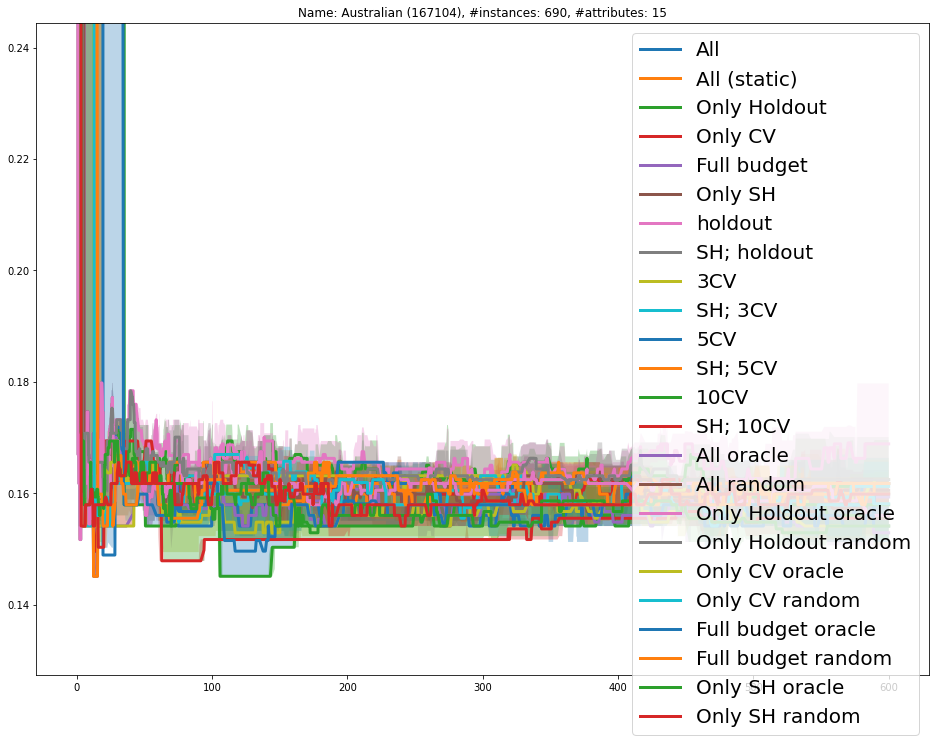

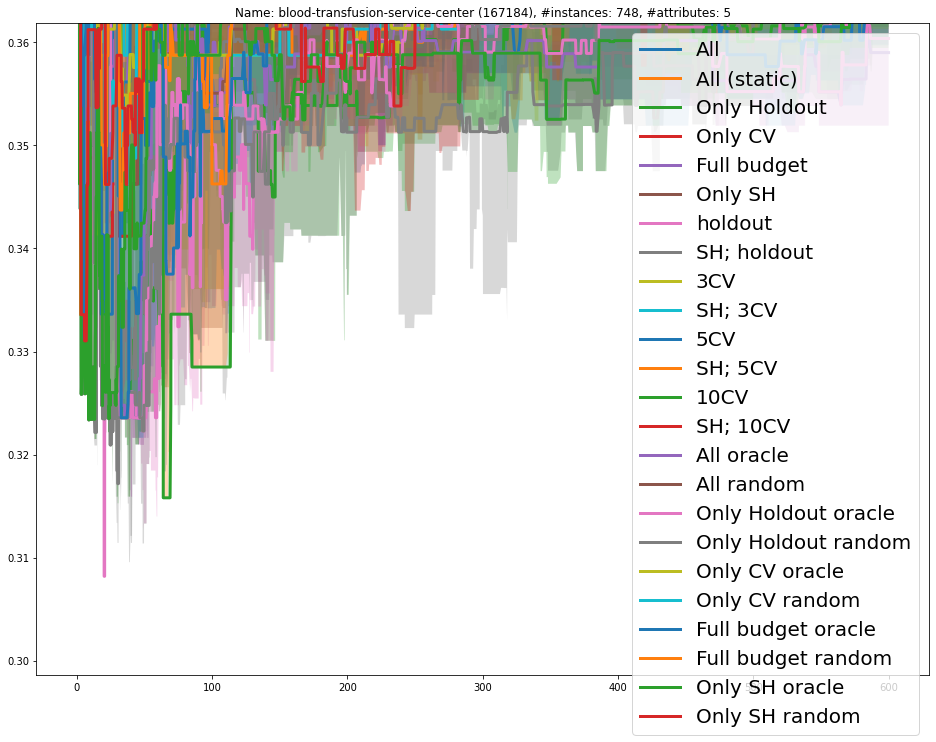

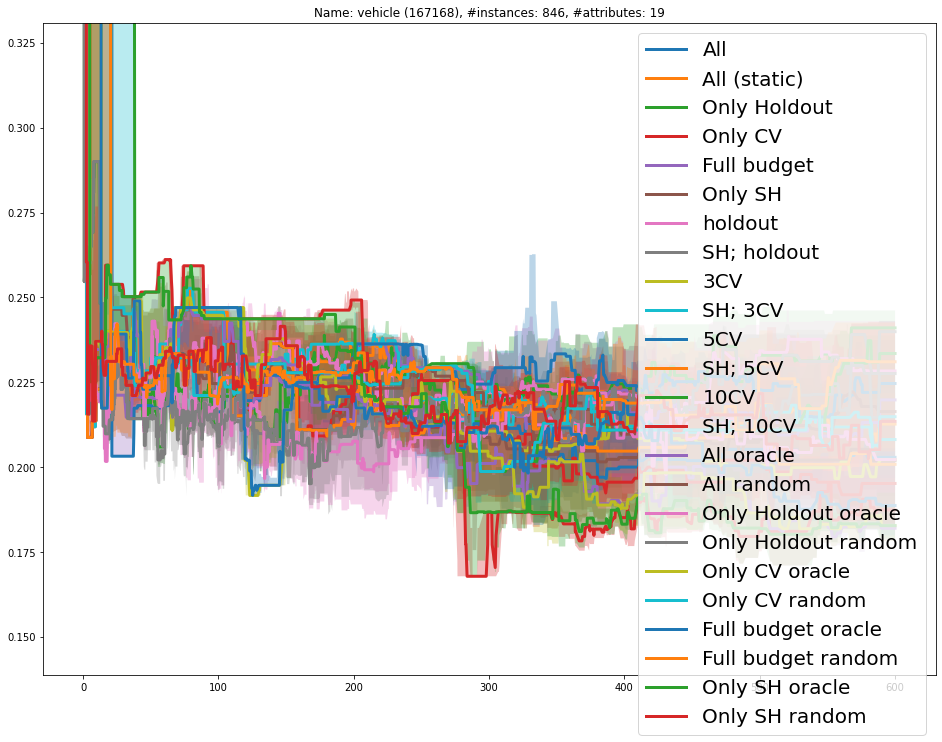

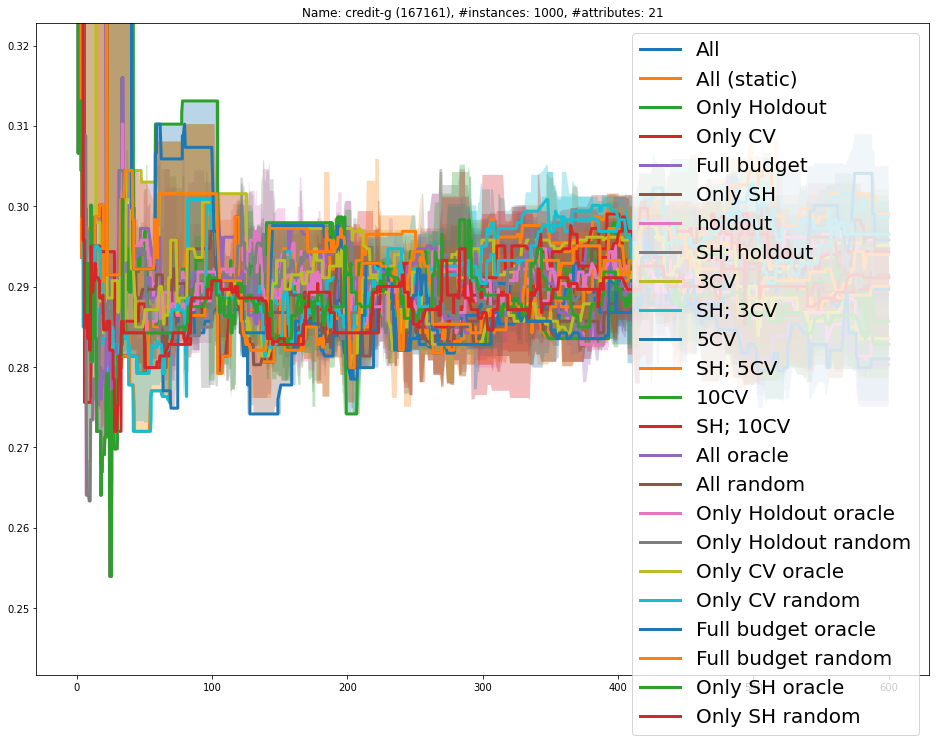

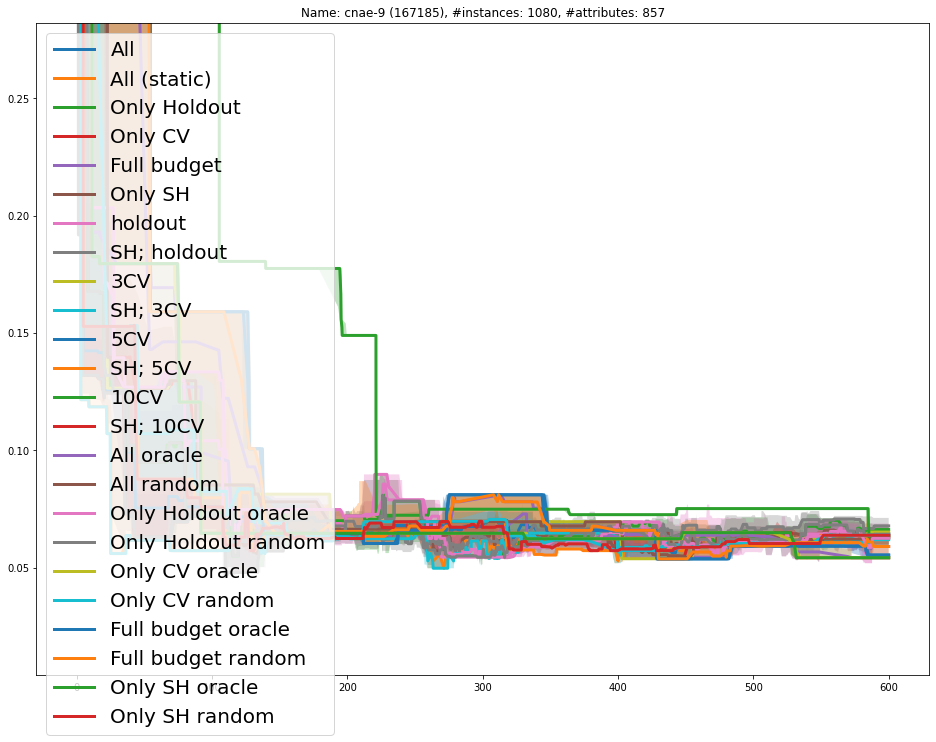

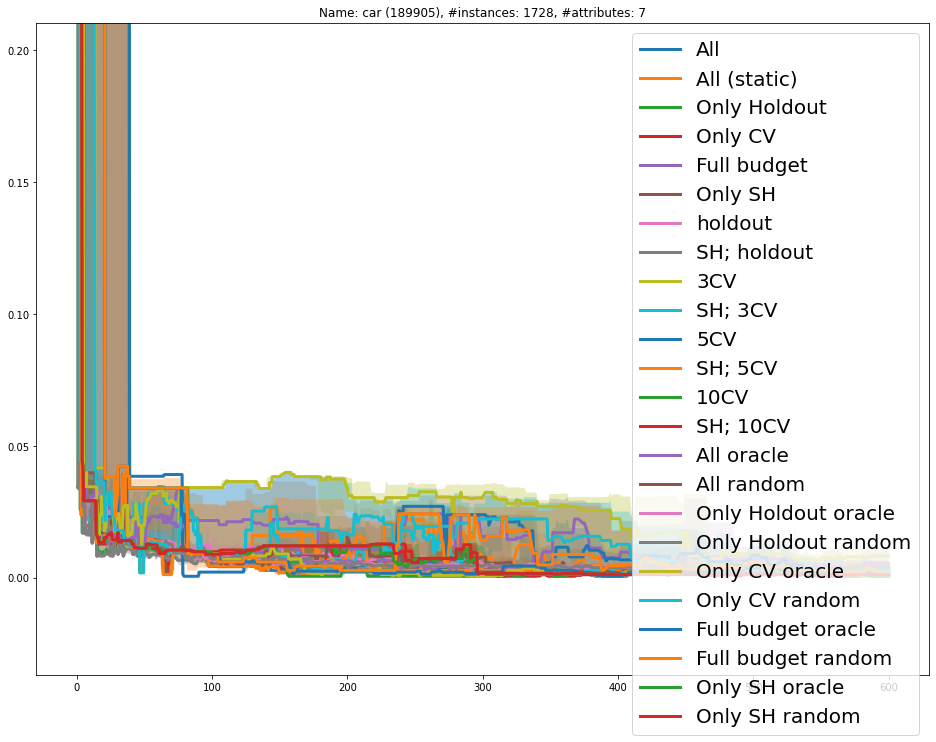

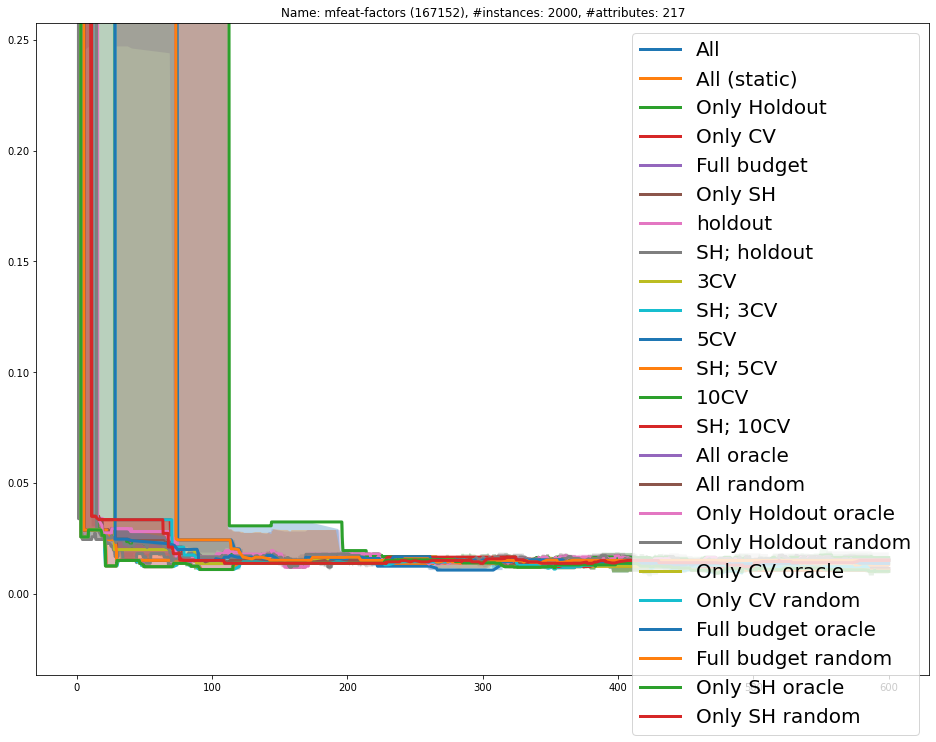

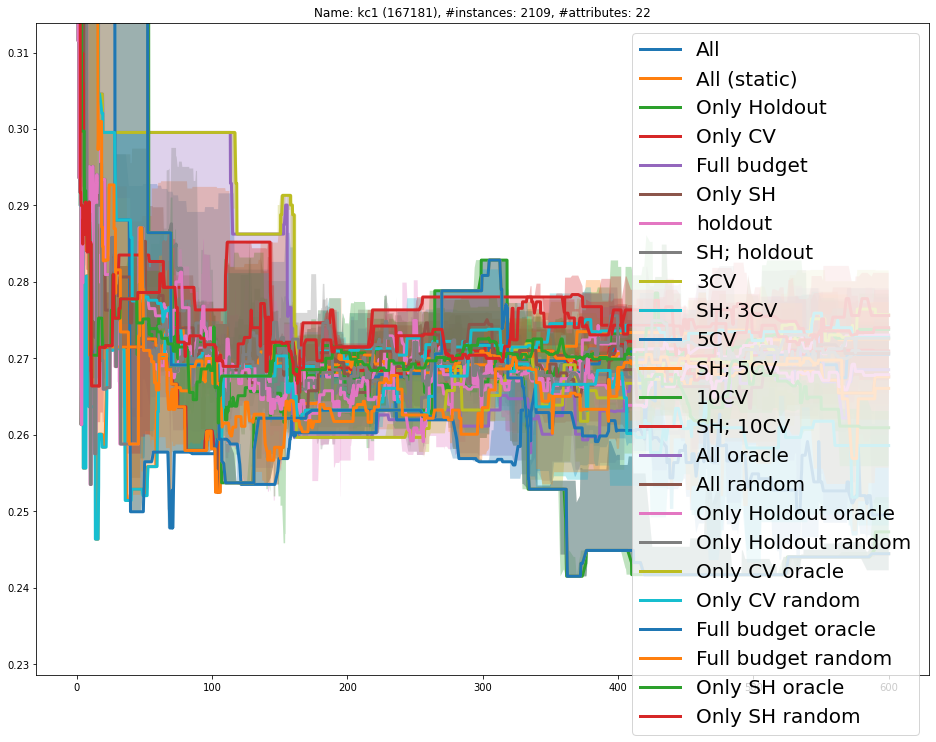

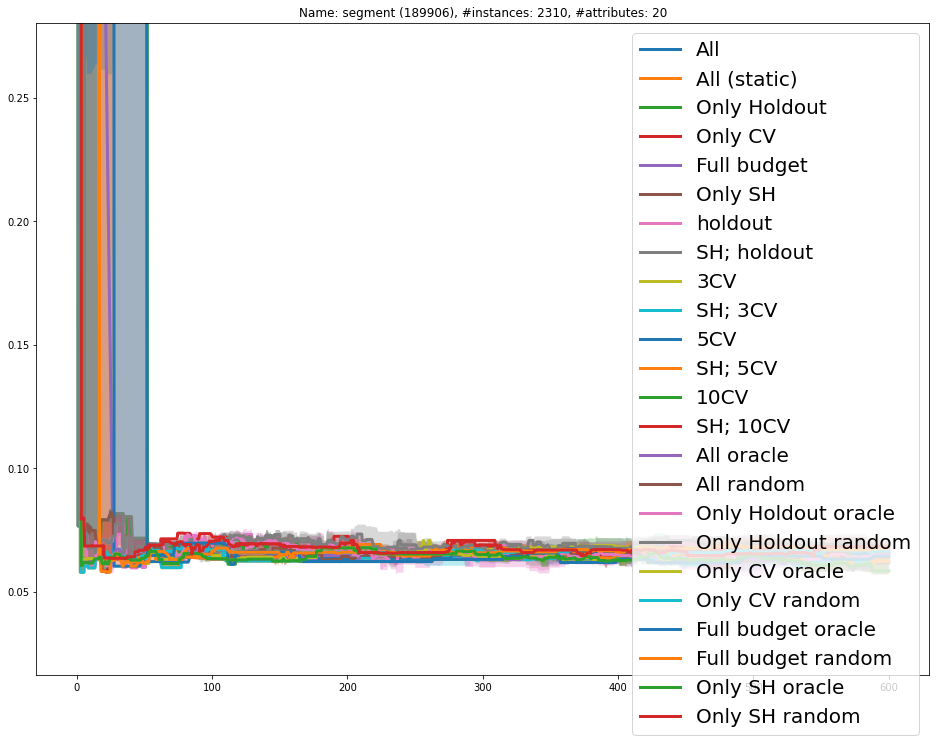

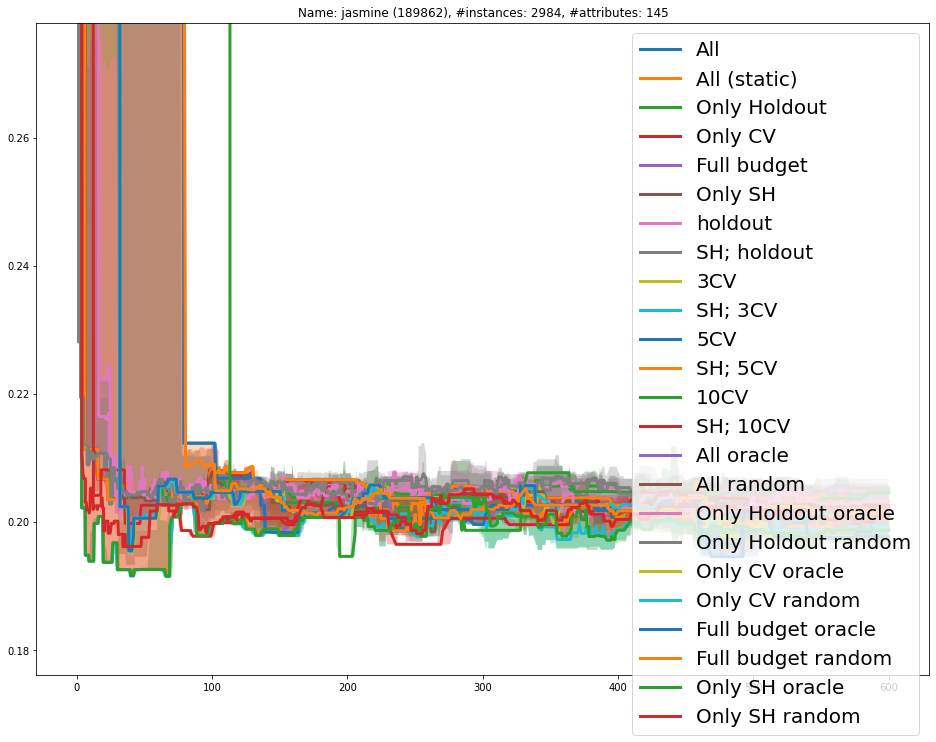

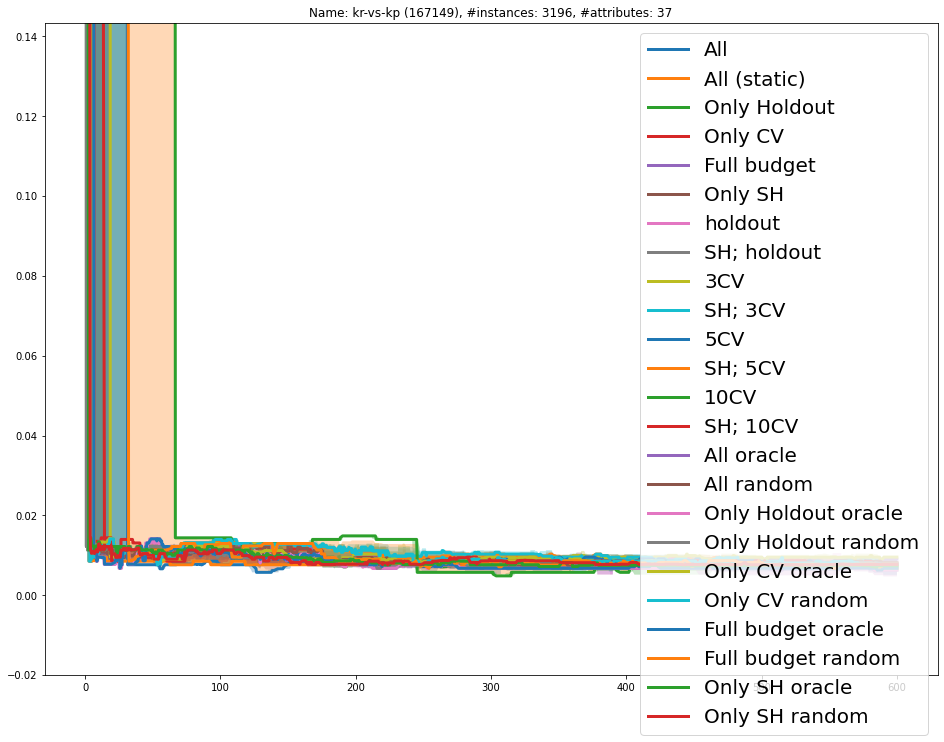

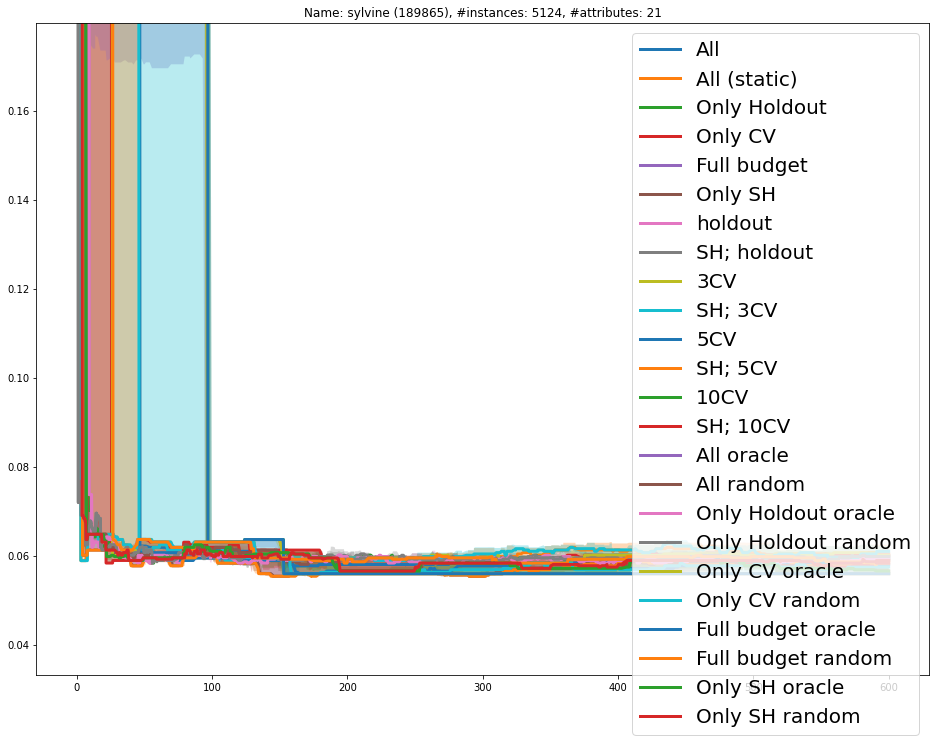

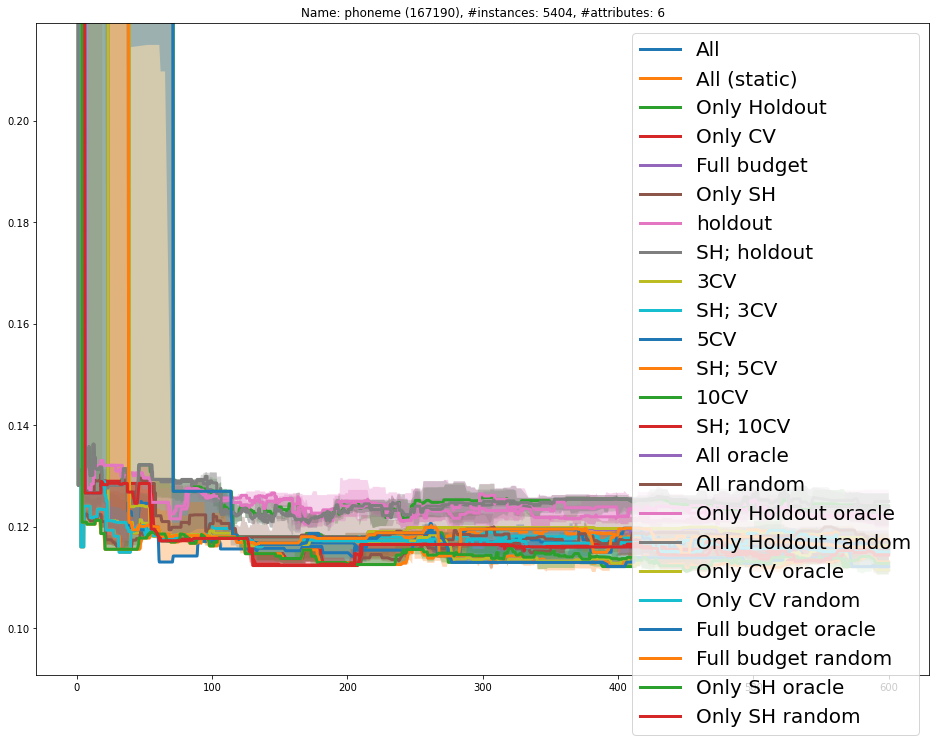

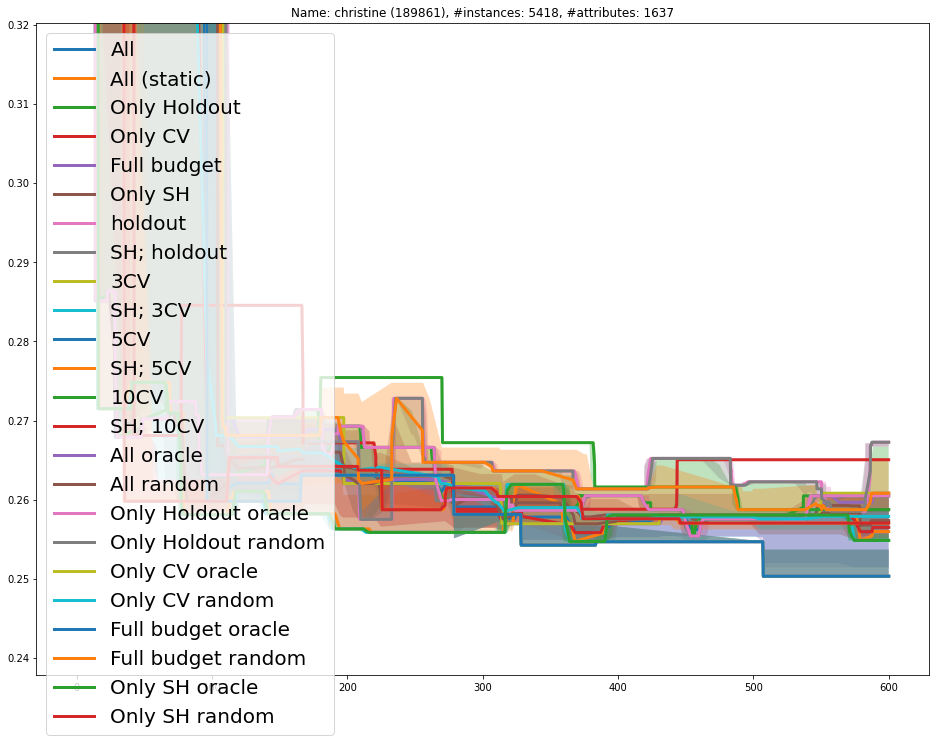

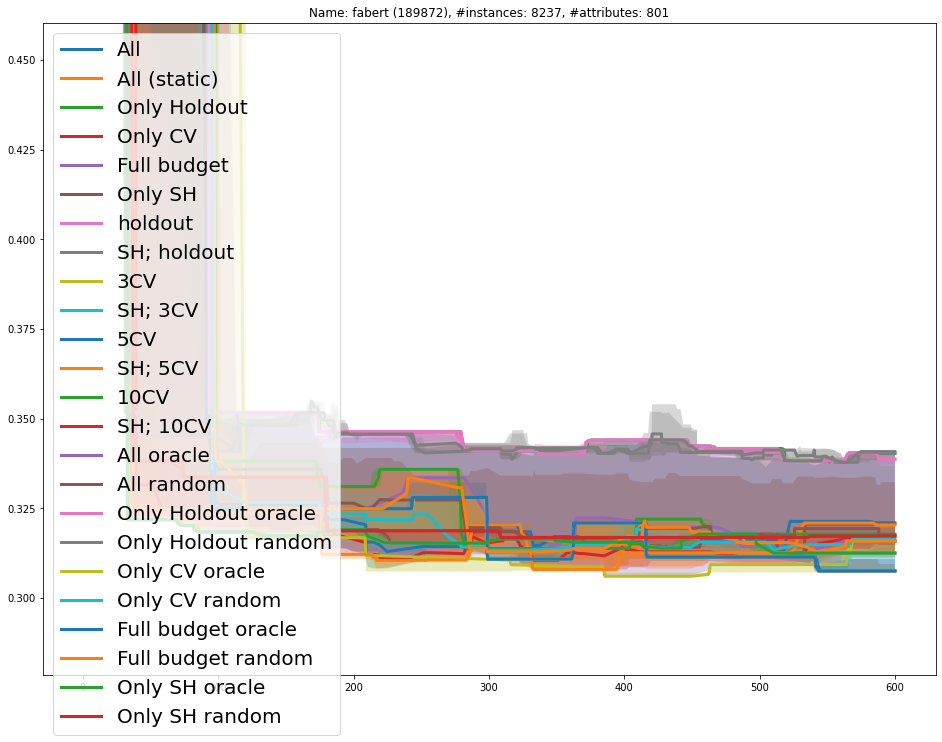

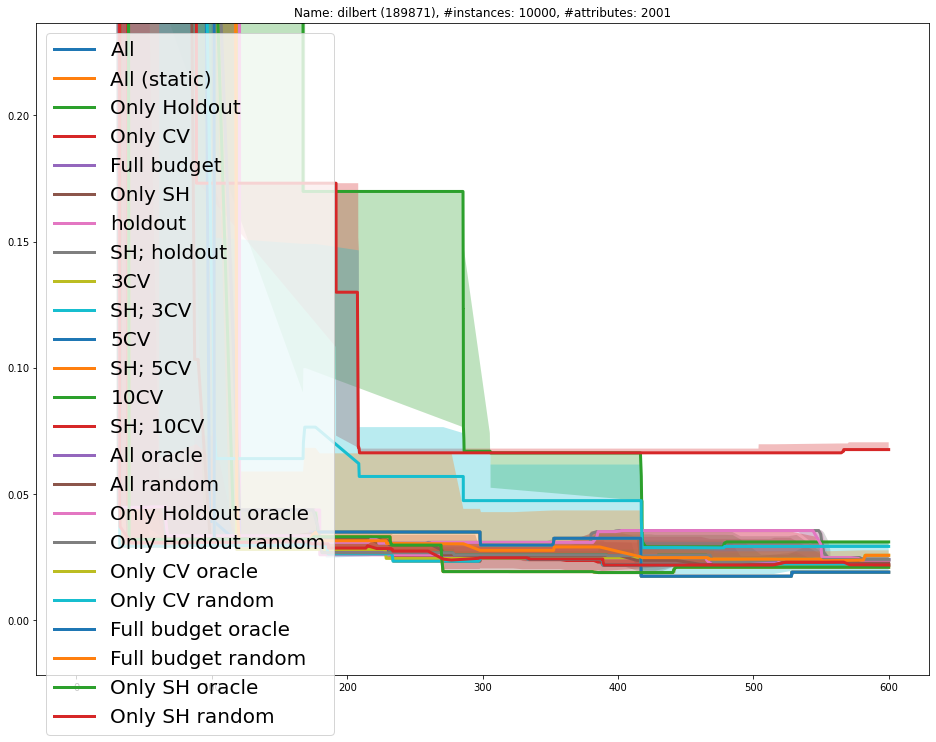

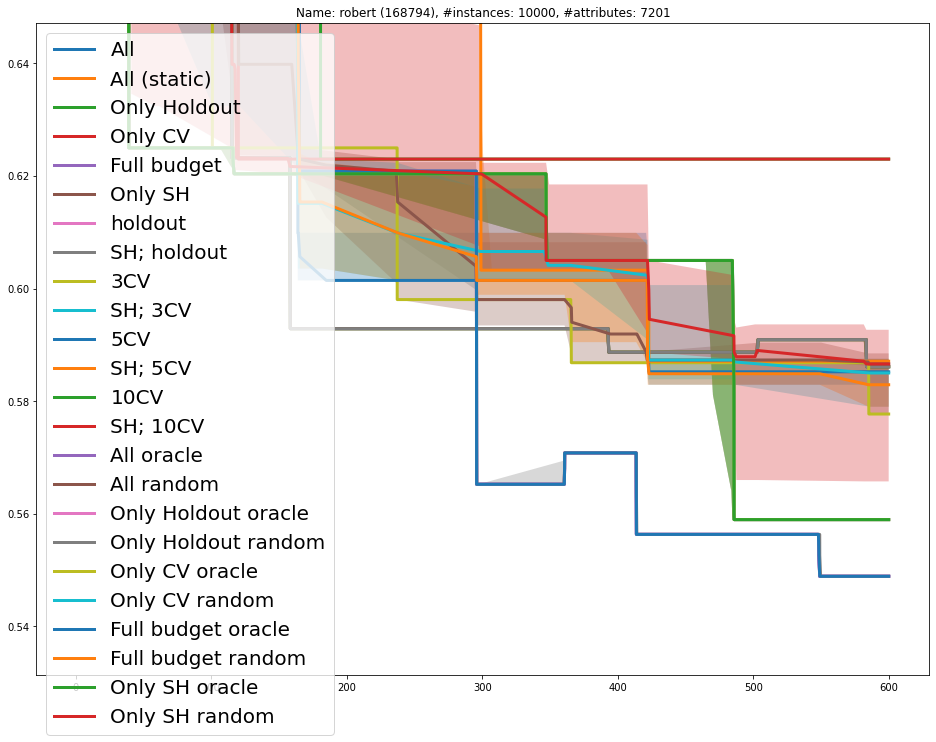

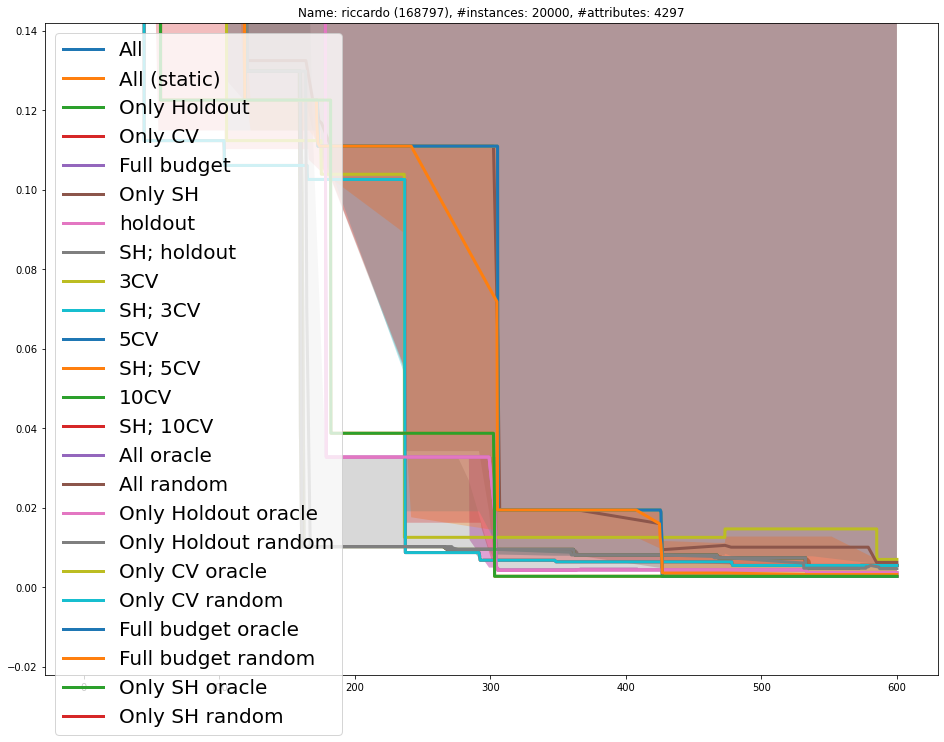

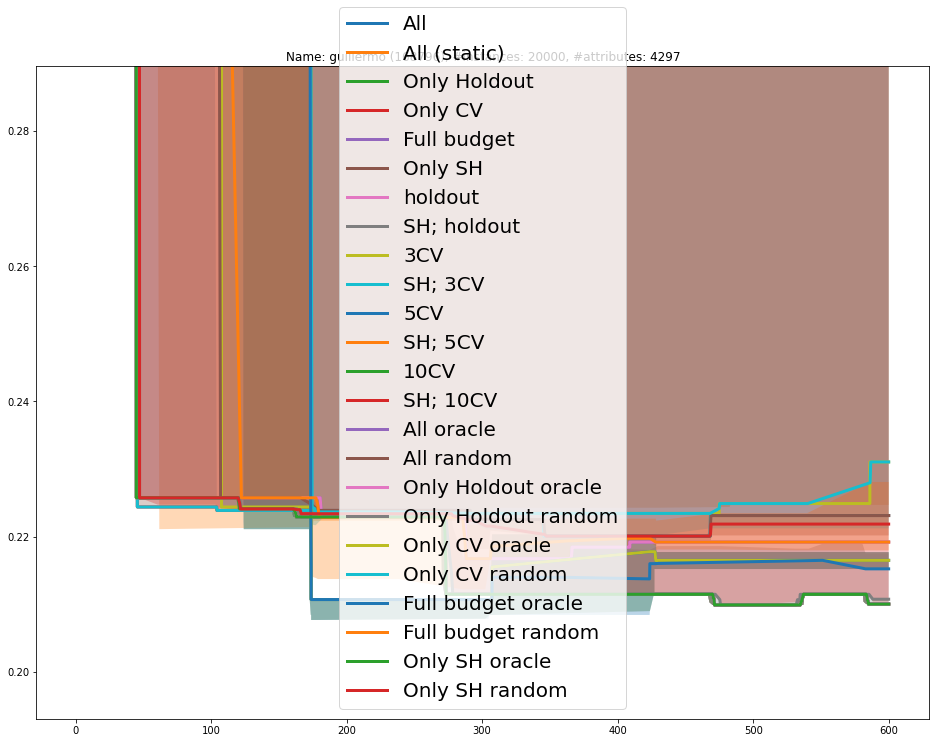

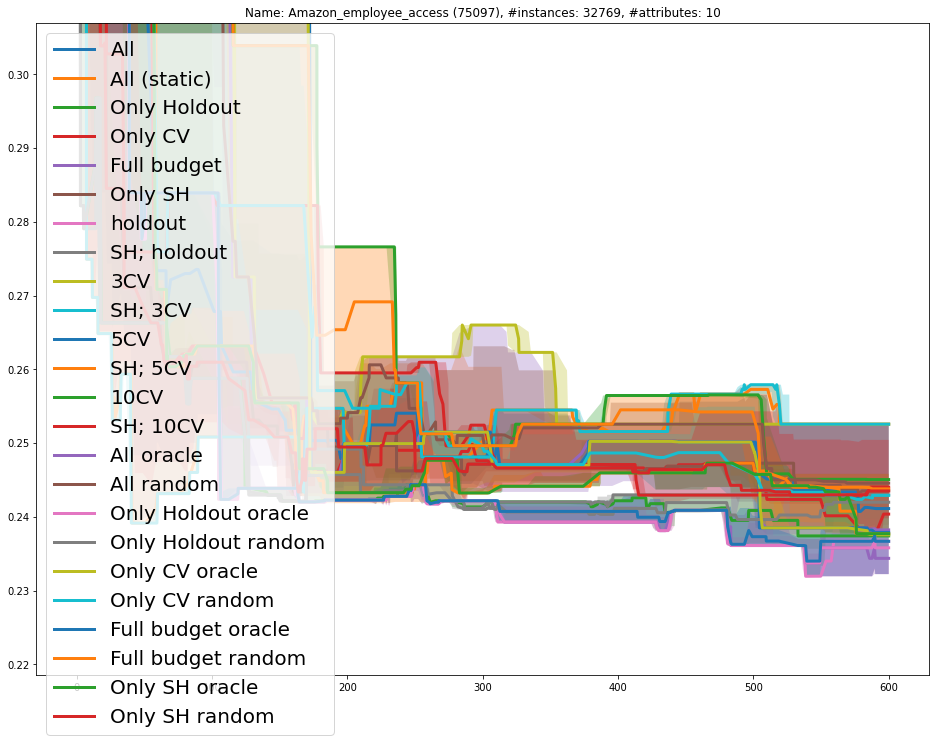

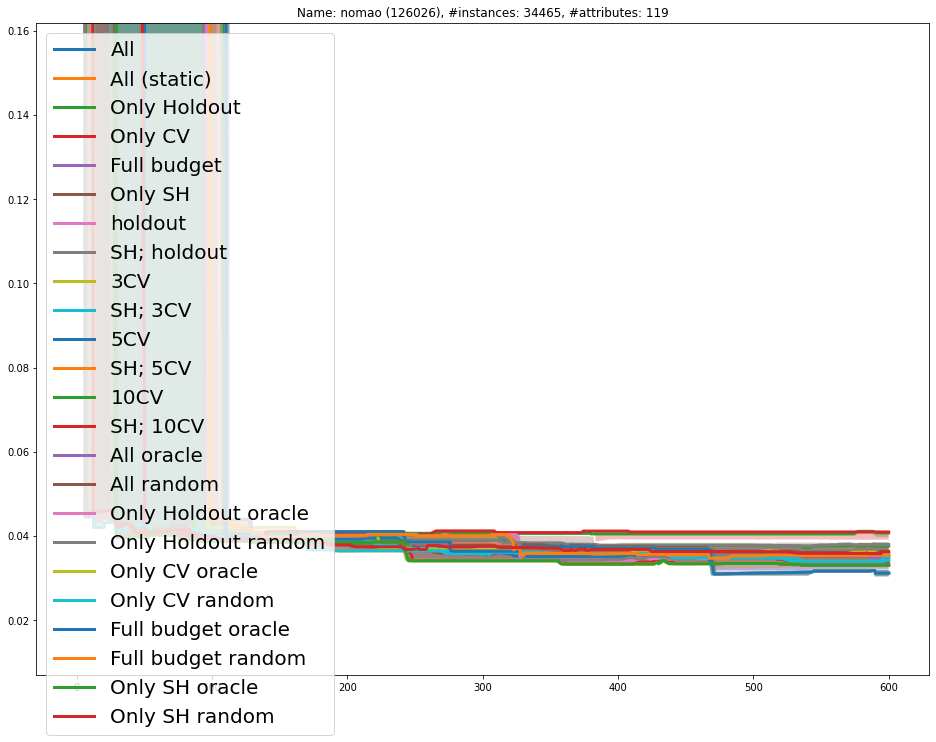

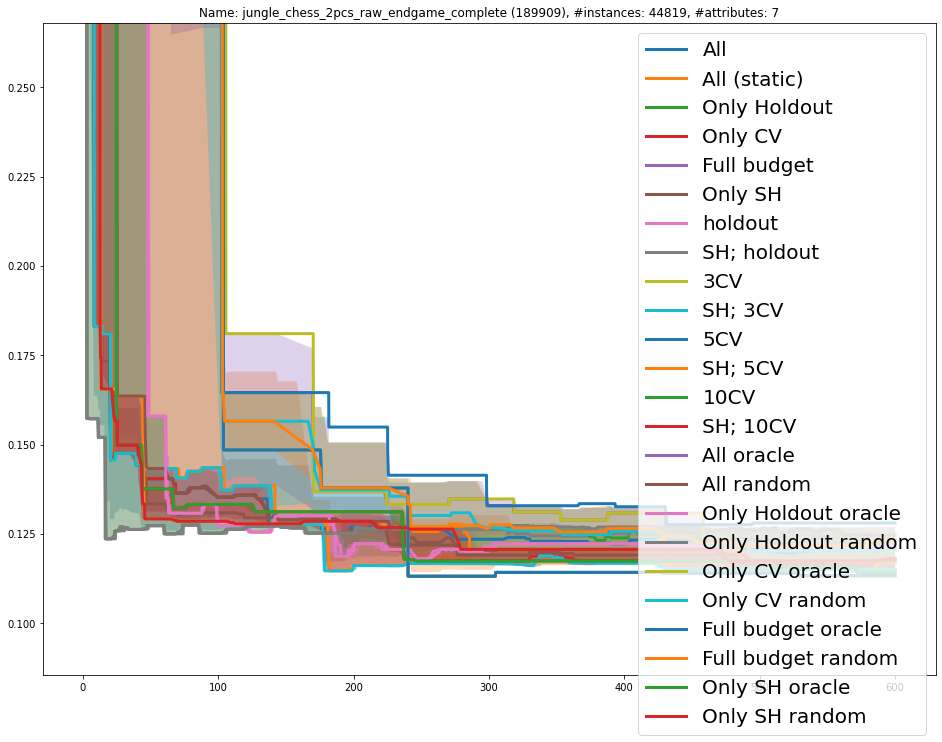

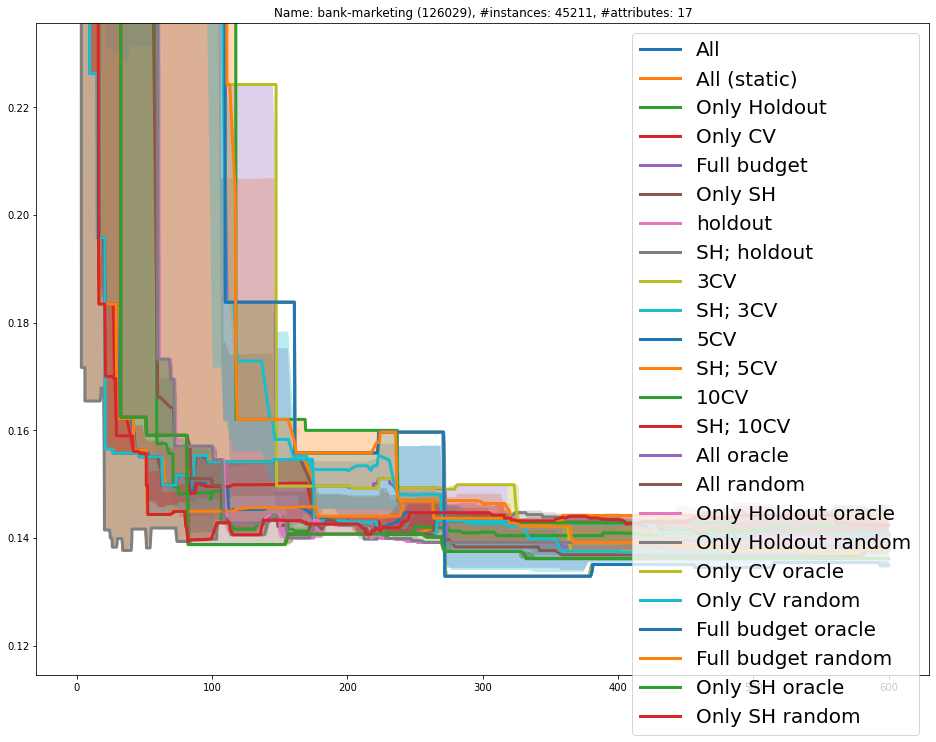

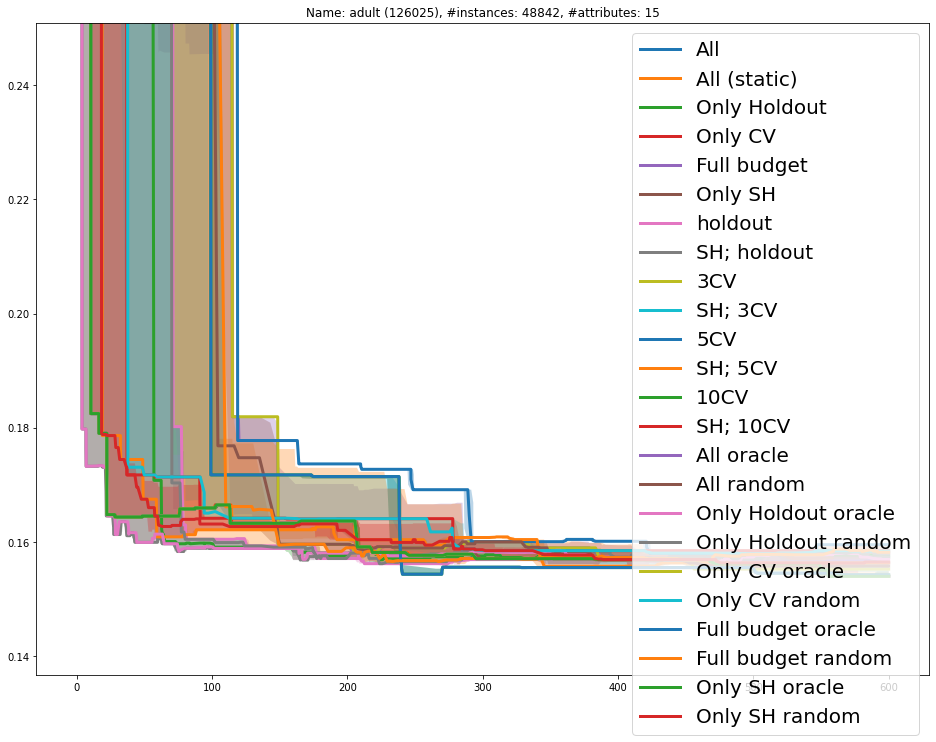

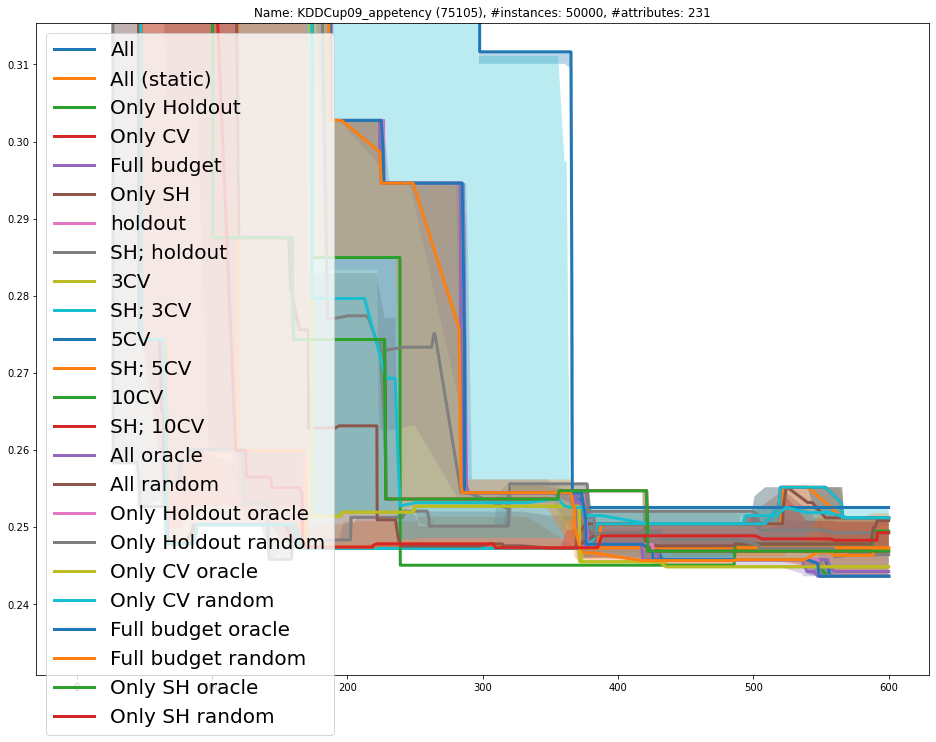

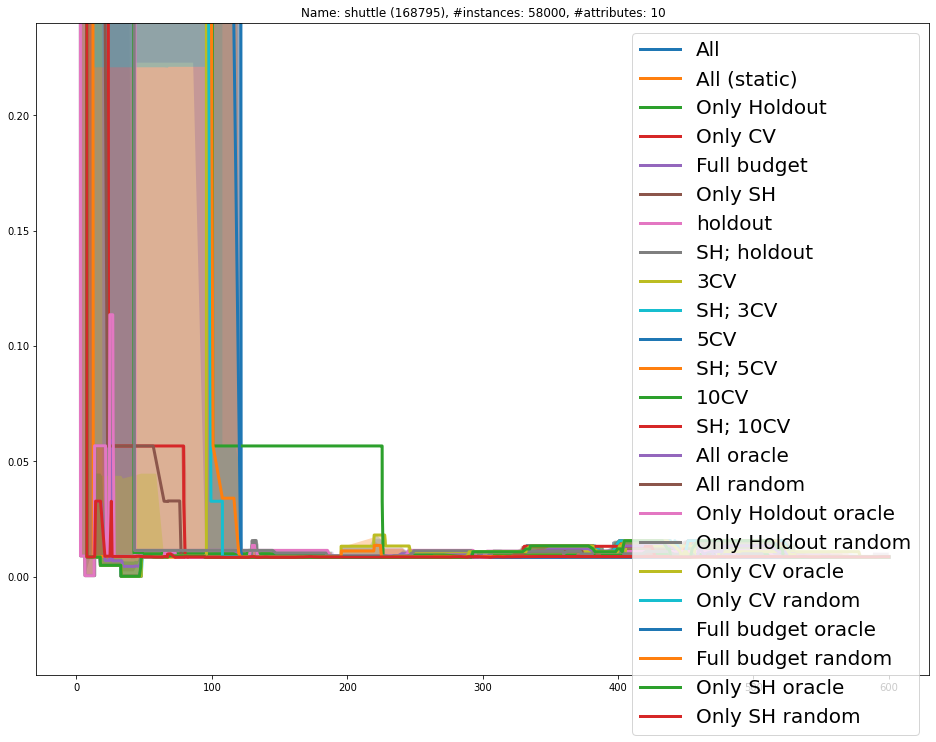

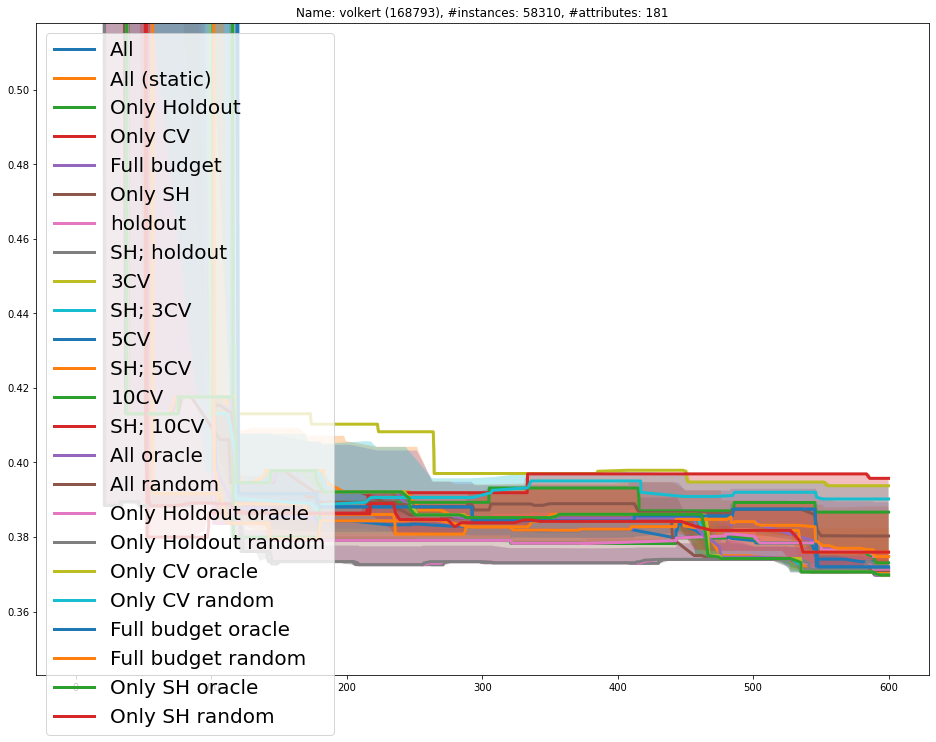

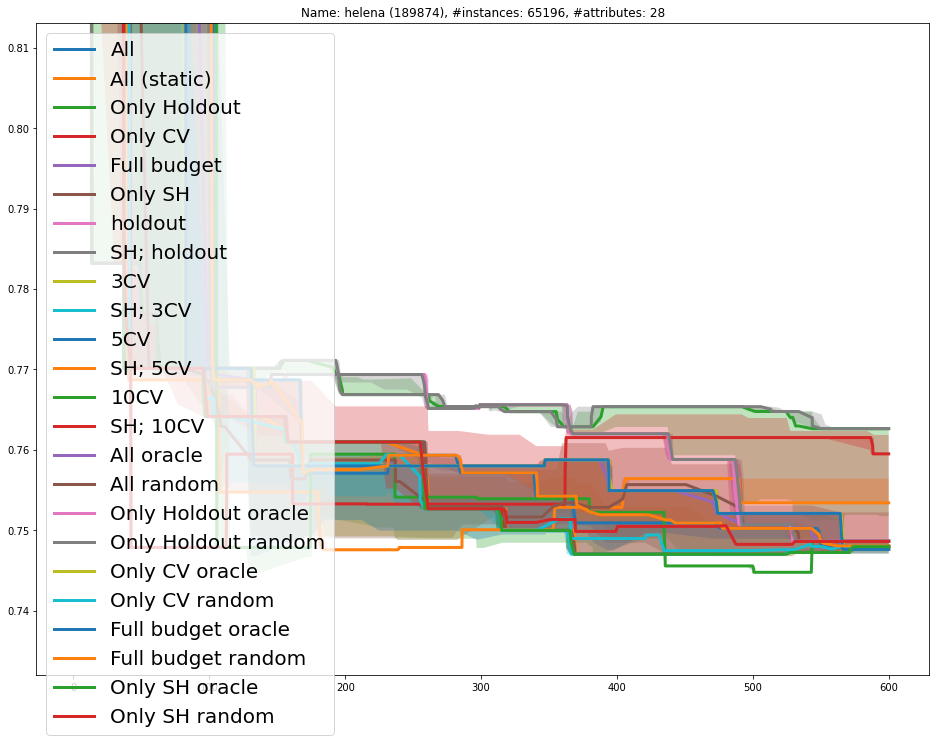

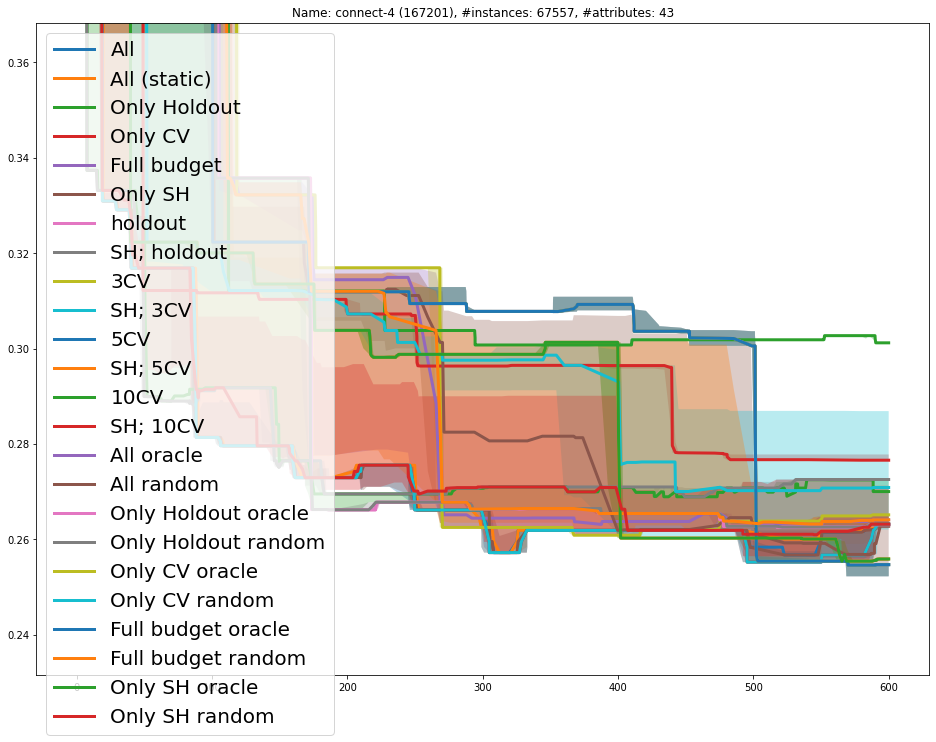

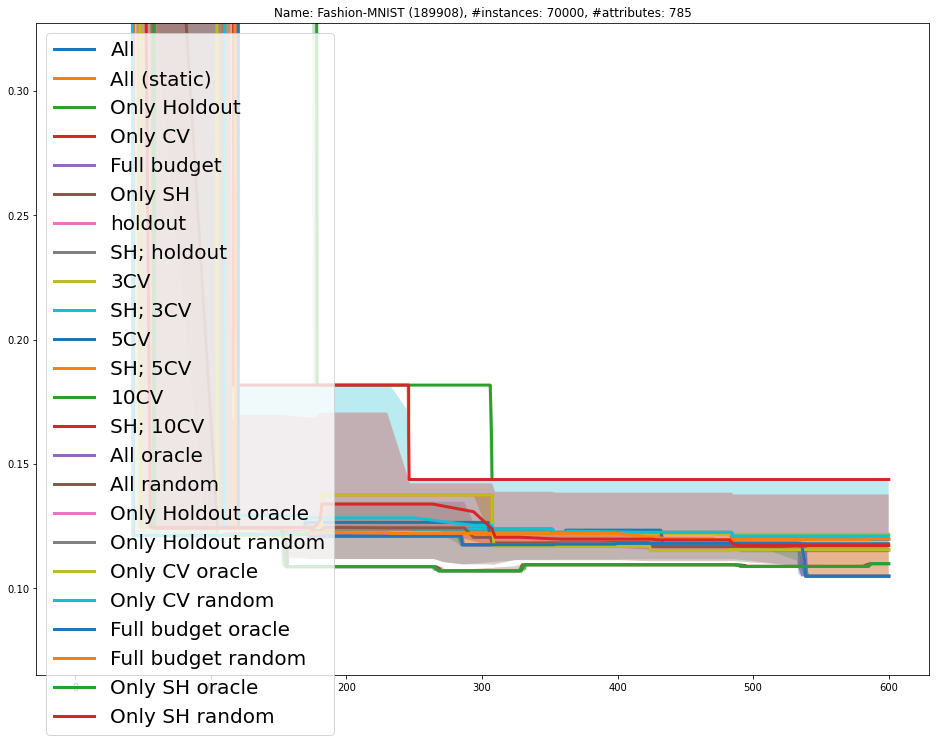

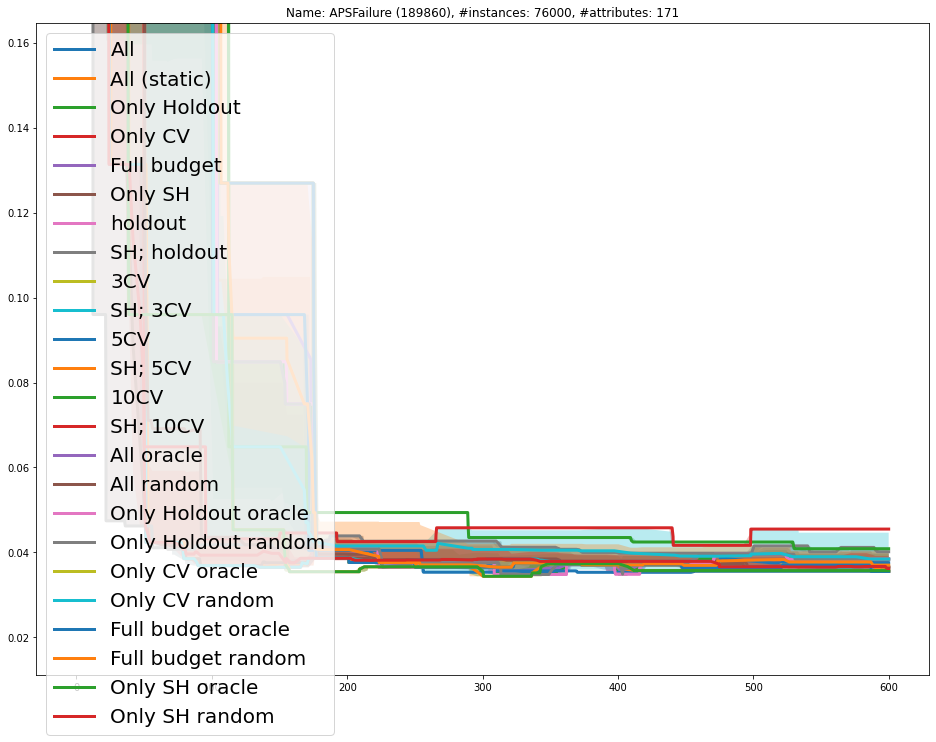

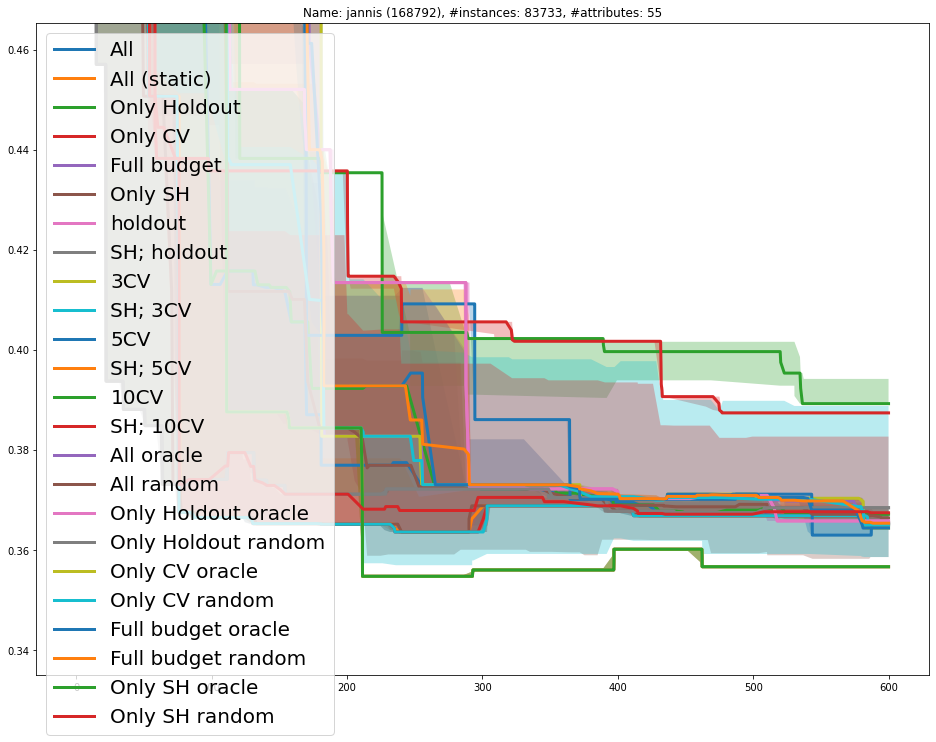

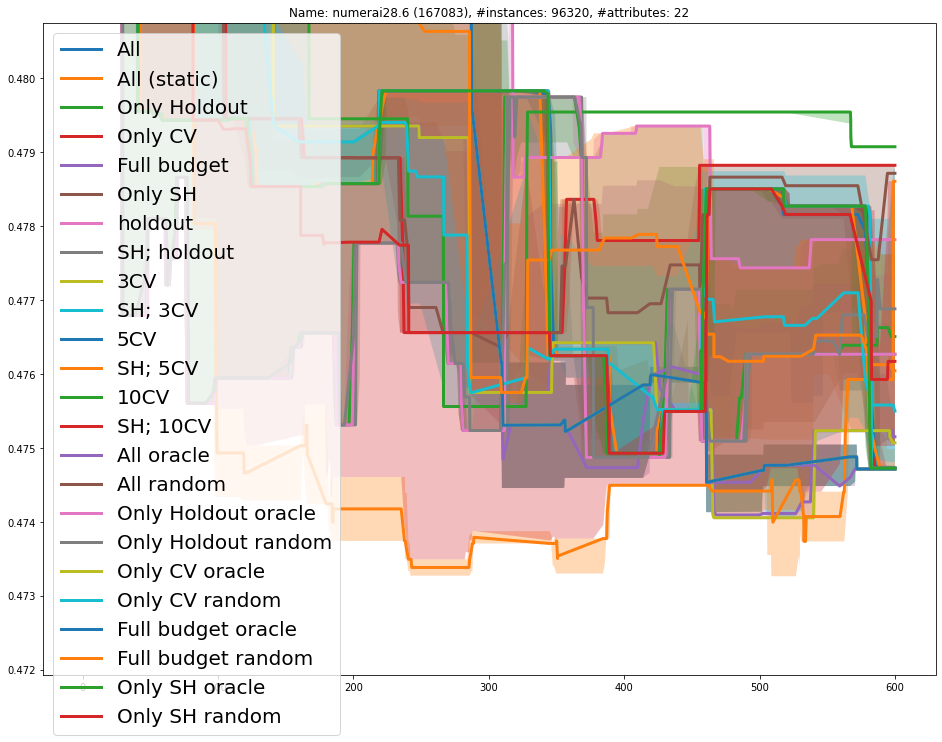

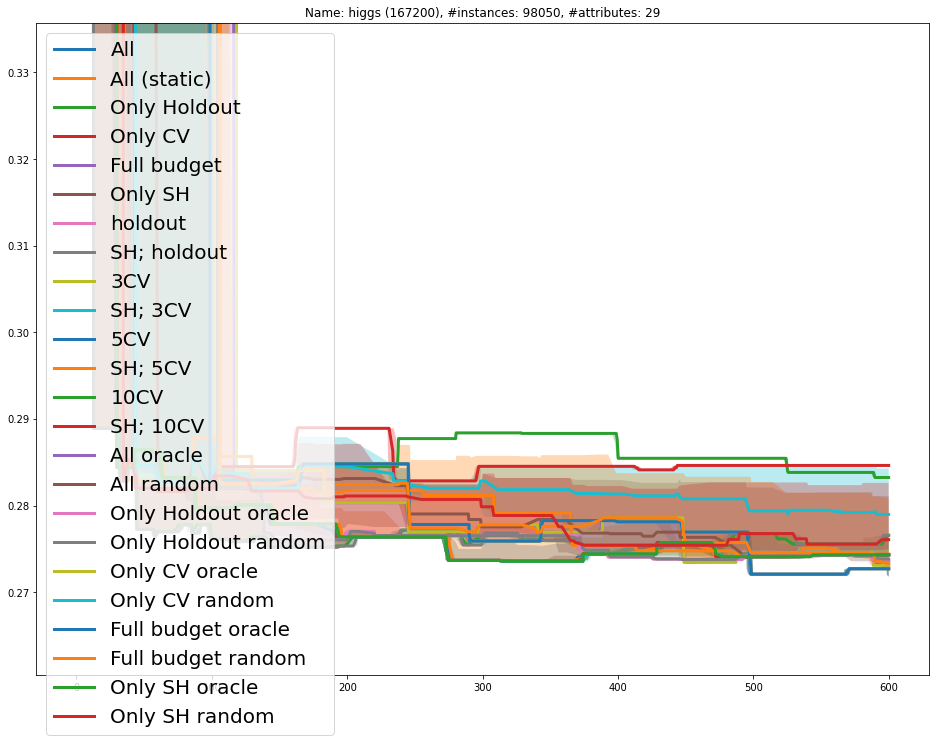

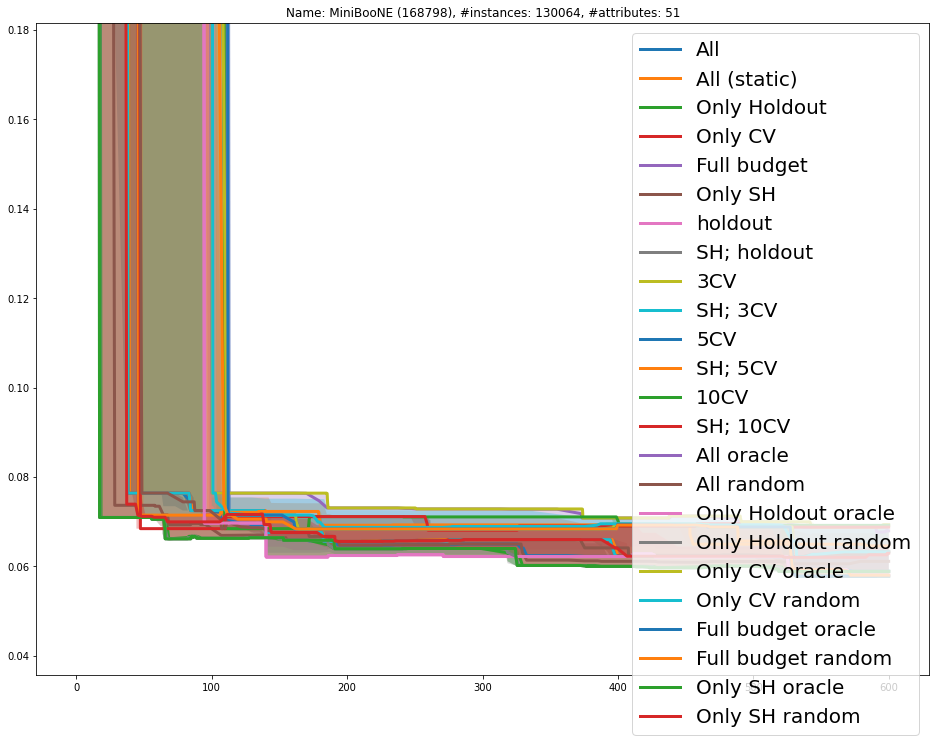

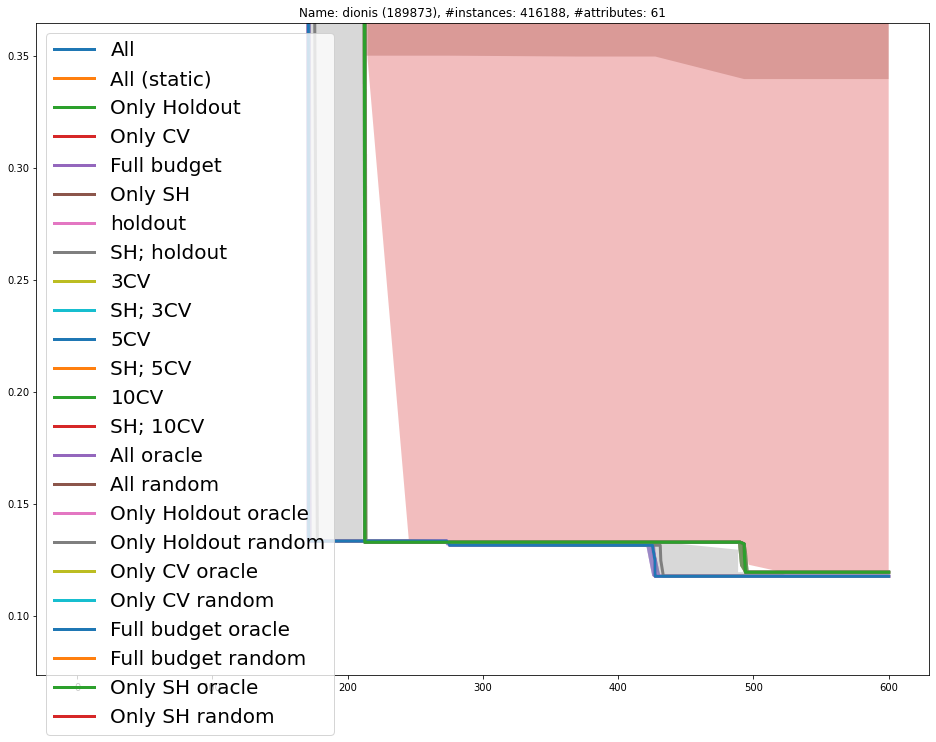

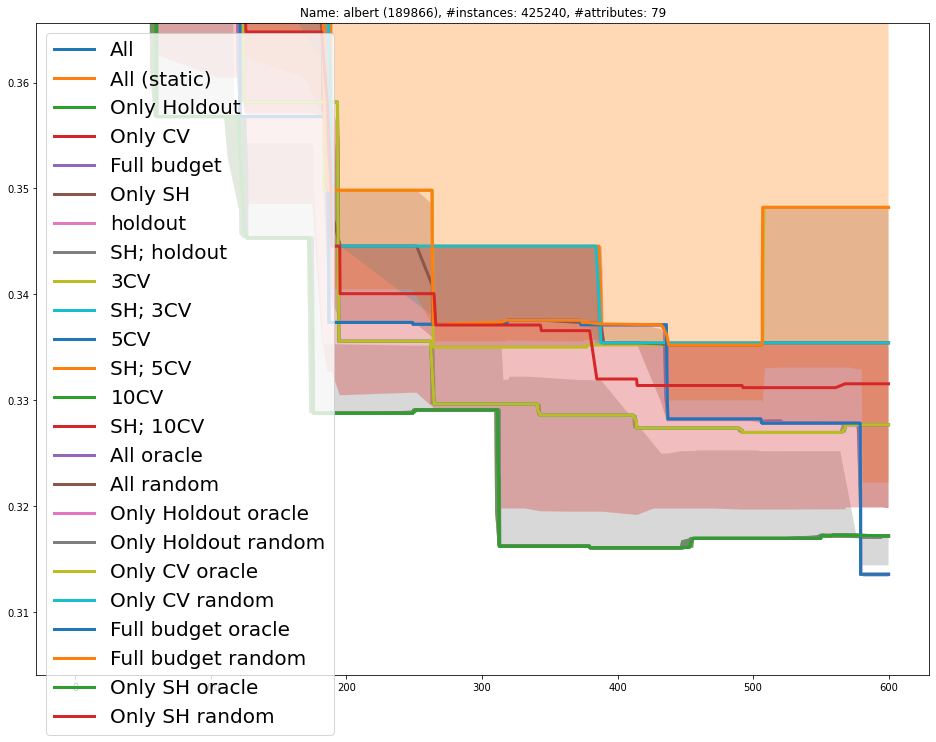

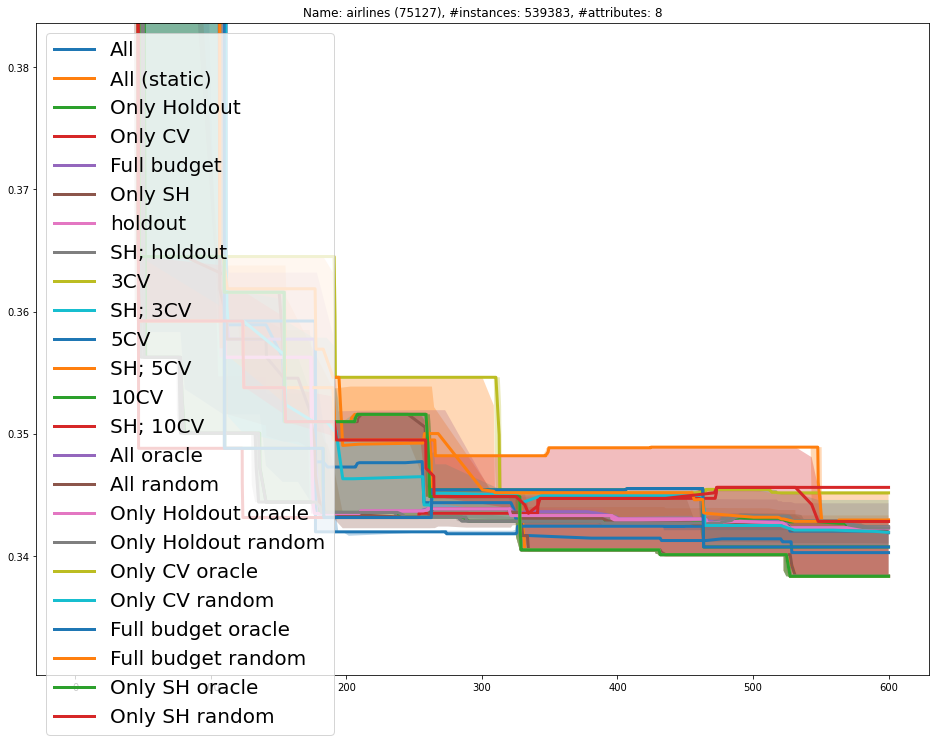

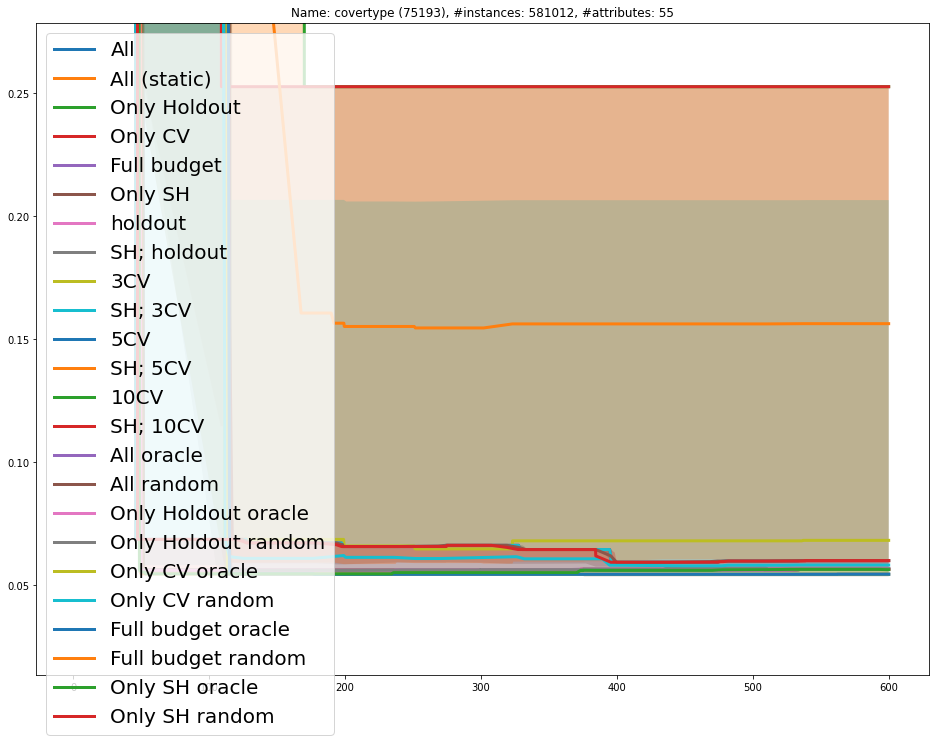

In [6]:
HORIZON = 10
for tid in task_ids_sorted_by_num_features:
    plt.figure(figsize=[16,12])
    colors = itertools.cycle(style_dc["colors"])
    for mode in list(valid_pretty[HORIZON].keys()):
        c = next(colors)
        tmp = pd.DataFrame(res_dc[HORIZON][tid][mode]).sort_index(axis=1).ffill(axis=1)
        med = tmp.median(axis=0)
        med.loc[HORIZON*60] = med.iloc[-1]
        low = tmp.quantile(0.25)
        low.loc[HORIZON*60] = low.iloc[-1]
        up = tmp.quantile(0.75, axis=0)
        up.loc[HORIZON*60] = up.iloc[-1]
        plt.plot(med.index, med.to_numpy(), label=valid_pretty[HORIZON][mode], linewidth=3)
        plt.fill_between(med.index, low, up, alpha=0.3)
    plt.title('Name: %s (%d), #instances: %d, #attributes: %d' % (
        tasks.loc[tid, 'name'], tid, tasks.loc[tid, 'NumberOfInstances'], tasks.loc[tid, 'NumberOfFeatures']))
    plt.legend(fontsize=20)
    plt.ylim([plt.ylim()[0], plt.ylim()[0] + 0.3*(plt.ylim()[1]-plt.ylim()[0])])
    #plt.yscale("log")
    plt.show()

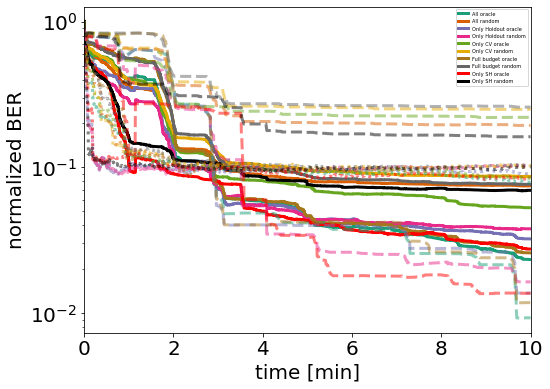

In [7]:
# Plot average BER across all datasets
HORIZON = 10
model_list = []
for m in valid_pretty[HORIZON].keys():
    if m[0] in ("artificial", ): #None):
        model_list.append(m)
average_plot(model_list=model_list, res_dc=res_dc, valid_pretty=valid_pretty,
             horizon=HORIZON, task_ids_sorted_by_num_features=task_ids_sorted_by_num_features,
             min_diff_dc=min_diff_dc)
plt.yscale("log")
plt.legend(fontsize=5)
plt.show()

In [8]:
# Assume we have either all or no models
horizon_list = sorted(list(valid_pretty.keys()))
model_list = {}
for h in horizon_list:
    model_list[h] = []
    for m in valid_pretty[h].keys():
        if m[0] in (None, "artificial"):
            model_list[h].append(m)
print(model_list)
tab_data, stat_test_data = collect_data_for_final_table(
    model_list, res_dc, valid_pretty, horizon_list,
    task_ids_sorted_by_num_features, min_diff_dc, n_seeds=n_seeds)

{10: [(None, '10MIN/RQ1_AutoAuto_simulate/dynamic/'), (None, '10MIN/RQ1_AutoAuto_simulate/static/'), (None, '10MIN/RQ2.1_AutoAuto_simulate/no_cv/dynamic/'), (None, '10MIN/RQ2.1_AutoAuto_simulate/only_cv/dynamic/'), (None, '10MIN/RQ2.1_AutoAuto_simulate/no_sh/dynamic/'), (None, '10MIN/RQ2.1_AutoAuto_simulate/only_sh/dynamic/'), ('artificial', 'All oracle'), ('artificial', 'All random'), ('artificial', 'Only Holdout oracle'), ('artificial', 'Only Holdout random'), ('artificial', 'Only CV oracle'), ('artificial', 'Only CV random'), ('artificial', 'Full budget oracle'), ('artificial', 'Full budget random'), ('artificial', 'Only SH oracle'), ('artificial', 'Only SH random')], 60: [(None, '60MIN/RQ1_AutoAuto_simulate/dynamic/'), (None, '60MIN/RQ1_AutoAuto_simulate/static/'), (None, '60MIN/RQ2.1_AutoAuto_simulate/no_cv/dynamic/'), (None, '60MIN/RQ2.1_AutoAuto_simulate/only_cv/dynamic/'), (None, '60MIN/RQ2.1_AutoAuto_simulate/no_sh/dynamic/'), (None, '60MIN/RQ2.1_AutoAuto_simulate/only_sh/dyna

In [9]:
# Do a test per setting
# ALL
not_different = do_wilcoxon_test(stat_test_data, model_list, horizon_list, valid_pretty, 
                                 exclude=[
                                     #(None, '60MIN/RQ1_AutoAuto_simulate/dynamic/360/'),
                                     (None, '60MIN/RQ2.1_AutoAuto_simulate/no_cv/dynamic/360/'),
                                     (None, '60MIN/RQ2.1_AutoAuto_simulate/only_cv/dynamic/360/'),
                                     (None, '60MIN/RQ2.1_AutoAuto_simulate/no_sh/dynamic/360/'),
                                     (None, '60MIN/RQ2.1_AutoAuto_simulate/only_sh/dynamic/360/'),
                                     ('holdout',), ('3CV',), ('5CV', ), ('10CV',),
                                     ('holdout', 'sh'), ('3CV', 'sh'),  ('5CV', 'sh'), ('10CV', 'sh'),
                                     #('artificial', 'All oracle'), ('artificial', 'All random'), 
                                     ('artificial', 'Only Holdout oracle'), ('artificial', 'Only Holdout random'),
                                     ('artificial', 'Only CV oracle'), ('artificial', 'Only CV random'),  
                                     ('artificial', 'Full budget oracle'), ('artificial', 'Full budget random'),
                                     ('artificial', 'Only SH oracle'), ('artificial', 'Only SH random'),
                                 ]
                                )
print("ALL")
print(not_different)
# Only holdout
not_different = do_wilcoxon_test(stat_test_data, model_list, horizon_list, valid_pretty, 
                                 exclude=[
                                     (None, '60MIN/RQ1_AutoAuto_simulate/dynamic/360/'),
                                     #(None, '60MIN/RQ2.1_AutoAuto_simulate/no_cv/dynamic/360/'),
                                     (None, '60MIN/RQ2.1_AutoAuto_simulate/only_cv/dynamic/360/'),
                                     (None, '60MIN/RQ2.1_AutoAuto_simulate/no_sh/dynamic/360/'),
                                     (None, '60MIN/RQ2.1_AutoAuto_simulate/only_sh/dynamic/360/'),
                                     ('holdout',), ('3CV',), ('5CV', ), ('10CV',),
                                     ('holdout', 'sh'), ('3CV', 'sh'),  ('5CV', 'sh'), ('10CV', 'sh'),
                                     ('artificial', 'All oracle'), ('artificial', 'All random'), 
                                     #('artificial', 'Only Holdout oracle'), ('artificial', 'Only Holdout random'),
                                     ('artificial', 'Only CV oracle'), ('artificial', 'Only CV random'),  
                                     ('artificial', 'Full budget oracle'), ('artificial', 'Full budget random'),
                                     ('artificial', 'Only SH oracle'), ('artificial', 'Only SH random'),
                                 ]
                                )
print("Only holdout")
print(not_different)
# Only CV
not_different = do_wilcoxon_test(stat_test_data, model_list, horizon_list, valid_pretty, 
                                 exclude=[
                                     (None, '60MIN/RQ1_AutoAuto_simulate/dynamic/360/'),
                                     (None, '60MIN/RQ2.1_AutoAuto_simulate/no_cv/dynamic/360/'),
                                     #(None, '60MIN/RQ2.1_AutoAuto_simulate/only_cv/dynamic/360/'),
                                     (None, '60MIN/RQ2.1_AutoAuto_simulate/no_sh/dynamic/360/'),
                                     (None, '60MIN/RQ2.1_AutoAuto_simulate/only_sh/dynamic/360/'),
                                     ('holdout',), ('3CV',), ('5CV', ), ('10CV',),
                                     ('holdout', 'sh'), ('3CV', 'sh'),  ('5CV', 'sh'), ('10CV', 'sh'),
                                     ('artificial', 'All oracle'), ('artificial', 'All random'), 
                                     ('artificial', 'Only Holdout oracle'), ('artificial', 'Only Holdout random'),
                                     #('artificial', 'Only CV oracle'), ('artificial', 'Only CV random'),  
                                     ('artificial', 'Full budget oracle'), ('artificial', 'Full budget random'),
                                     ('artificial', 'Only SH oracle'), ('artificial', 'Only SH random'),
                                 ]
                                )
print("Only CV")
print(not_different)
# Only SH
not_different = do_wilcoxon_test(stat_test_data, model_list, horizon_list, valid_pretty, 
                                 exclude=[
                                     (None, '60MIN/RQ1_AutoAuto_simulate/dynamic/360/'),
                                     (None, '60MIN/RQ2.1_AutoAuto_simulate/no_cv/dynamic/360/'),
                                     (None, '60MIN/RQ2.1_AutoAuto_simulate/only_cv/dynamic/360/'),
                                     (None, '60MIN/RQ2.1_AutoAuto_simulate/no_sh/dynamic/360/'),
                                     #(None, '60MIN/RQ2.1_AutoAuto_simulate/only_sh/dynamic/360/'),
                                     ('holdout',), ('3CV',), ('5CV', ), ('10CV',),
                                     ('holdout', 'sh'), ('3CV', 'sh'),  ('5CV', 'sh'), ('10CV', 'sh'),
                                     ('artificial', 'All oracle'), ('artificial', 'All random'), 
                                     ('artificial', 'Only Holdout oracle'), ('artificial', 'Only Holdout random'),
                                     ('artificial', 'Only CV oracle'), ('artificial', 'Only CV random'),  
                                     ('artificial', 'Full budget oracle'), ('artificial', 'Full budget random'),
                                     #('artificial', 'Only SH oracle'), ('artificial', 'Only SH random'),
                                 ]
                                )
print("Only SH")
print(not_different)
# Only Full Budget
not_different = do_wilcoxon_test(stat_test_data, model_list, horizon_list, valid_pretty, 
                                 exclude=[
                                     (None, '60MIN/RQ1_AutoAuto_simulate/dynamic/360/'),
                                     (None, '60MIN/RQ2.1_AutoAuto_simulate/no_cv/dynamic/360/'),
                                     (None, '60MIN/RQ2.1_AutoAuto_simulate/only_cv/dynamic/360/'),
                                     #(None, '60MIN/RQ2.1_AutoAuto_simulate/no_sh/dynamic/360/'),
                                     (None, '60MIN/RQ2.1_AutoAuto_simulate/only_sh/dynamic/360/'),
                                     ('holdout',), ('3CV',), ('5CV', ), ('10CV',),
                                     ('holdout', 'sh'), ('3CV', 'sh'),  ('5CV', 'sh'), ('10CV', 'sh'),
                                     ('artificial', 'All oracle'), ('artificial', 'All random'), 
                                     ('artificial', 'Only Holdout oracle'), ('artificial', 'Only Holdout random'),
                                     ('artificial', 'Only CV oracle'), ('artificial', 'Only CV random'),  
                                     #('artificial', 'Full budget oracle'), ('artificial', 'Full budget random'),
                                     ('artificial', 'Only SH oracle'), ('artificial', 'Only SH random'),
                                 ]
                                )
print("Only Full Budget")
print(not_different)

Not different with 10 mins:
	 
Not different with 60 mins:
	 
ALL
{10: [], 60: []}
Not different with 10 mins:
	 Only Holdout oracle vs All: 0.10484
	Only Holdout oracle vs All (static): 0.0946832
	Only Holdout oracle vs Only CV: 0.164322
	Only Holdout oracle vs Only SH: 0.127471
Not different with 60 mins:
	 Full budget vs All: 0.677427
	Full budget vs All (static): 0.417097
	Full budget vs Only CV: 0.472186
	Full budget vs Only SH: 0.625882
	Full budget vs Only Holdout oracle: 0.0791861
Only holdout
{10: [('Only Holdout oracle', 'All', 0.10483981716650786), ('Only Holdout oracle', 'All (static)', 0.09468316998532672), ('Only Holdout oracle', 'Only CV', 0.16432174524346194), ('Only Holdout oracle', 'Only SH', 0.12747077018821845)], 60: [('Full budget', 'All', 0.6774266716991387), ('Full budget', 'All (static)', 0.4170972806236682), ('Full budget', 'Only CV', 0.47218637703192484), ('Full budget', 'Only SH', 0.625881524512214), ('Full budget', 'Only Holdout oracle', 0.07918605831719266)

In [10]:
df = pd.DataFrame(tab_data)
#for horizon in horizon_list:
#    df['Rank_%s' % horizon] = df[horizon].rank(method='average', ascending=True)
print(df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &    10 &  STD 10 &    60 &  STD 60 \\
\midrule
All                 &  3.58 &    0.23 &  2.47 &    0.18 \\
All (static)        &  3.69 &    0.14 &  2.44 &    0.12 \\
Only Holdout        &  4.03 &    0.14 &  3.18 &    0.15 \\
Only CV             &  6.11 &    0.11 &  5.09 &    0.19 \\
Full budget         &  3.50 &    0.20 &  2.39 &    0.18 \\
Only SH             &  3.63 &    0.19 &  2.44 &    0.24 \\
All oracle          &  2.33 &    0.06 &  1.22 &    0.08 \\
All random          &  7.46 &    2.02 &  5.64 &    1.95 \\
Only Holdout oracle &  3.23 &    0.10 &  2.62 &    0.07 \\
Only Holdout random &  3.78 &    0.23 &  3.13 &    0.12 \\
Only CV oracle      &  5.28 &    0.06 &  3.94 &    0.10 \\
Only CV random      &  8.66 &    0.70 &  6.85 &    0.86 \\
Full budget oracle  &  2.59 &    0.09 &  1.51 &    0.06 \\
Full budget random  &  7.64 &    2.00 &  5.46 &    1.52 \\
Only SH oracle      &  2.75 &    0.07 &  1.68 &    0.12 \\
Only SH random      &  6.95 &   

[(None, '60MIN/RQ1_AutoAuto_simulate/dynamic/'), (None, '60MIN/RQ1_AutoAuto_simulate/static/'), (None, '60MIN/RQ2.1_AutoAuto_simulate/no_cv/dynamic/'), (None, '60MIN/RQ2.1_AutoAuto_simulate/only_cv/dynamic/'), (None, '60MIN/RQ2.1_AutoAuto_simulate/no_sh/dynamic/'), (None, '60MIN/RQ2.1_AutoAuto_simulate/only_sh/dynamic/')]
Plotting 6 models
0 / 200
50 / 200
100 / 200
150 / 200


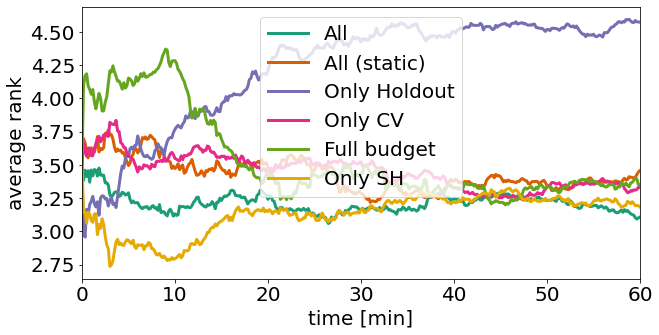

In [11]:
HORIZON = 60
model_list = []
for m in valid_pretty[HORIZON].keys():
    if m[0] not in (None, "artificial") or "oracle" in m[1] or 'random' in m[1]:
        continue
    model_list.append(m)
print(model_list)
rank(model_list, res_dc, valid_pretty, HORIZON, task_ids_sorted_by_num_features, n_iter=200, steplength=10)